In [4]:
%matplotlib widget
#%matplotlib inline

import seaborn as sns
sns.set_theme()
sns.set_context('talk')

import os, glob, re
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import RectangleSelector

import ipywidgets as ipw
from ipywidgets import interact, fixed
from IPython.display import display

from collections import OrderedDict

import xrayutilities as xu
import fabio
from silx.io.specfile import SpecFile

import pandas as pd
from natsort import natsorted, os_sorted

import warnings
warnings.filterwarnings('ignore')

AA = '\mathrm{\AA}^{-1}'
cmap='magma'

## Functions

In [5]:
def get_single_image(fname, n, mask=None):
    imgs = fabio.open(fname)
    img = imgs.get_frame(n).data.astype(float)
    
    if mask is not None:
        img[mask == 1] = np.nan
        
    img[514:551, :] = np.nan
    img[0, 1029] = np.nan
        
    img[img > 1e8] = np.nan
    
    return img


def read_img(fname, flip=False, mask=None):
    fname = str(fname)
    _, file_extension = os.path.splitext(fname)
    
    if file_extension == '.raw': 
        try:
            arr = np.asarray(np.fromfile(fname, dtype='int32', sep=""), dtype=float)
            arr.shape = (195, 487)
        except:
            print("Error reading file: %s" % file)
            return None
    else:
        try:
            arr = (fabio.open(tiff_file).data).astype(float)
        except:
            print("Error reading file: %s" % file)
            return None
        
    if flip:
        arr = np.fliplr(arr)  #for the way mounted at BL2-1
    
    return arr        
    

def get_from_spec_file(fname, scan_number, cols=None, return_labels=False):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    if return_labels:
        return spec_scan.labels

    spec_data = {}
    for col in cols:
        spec_data[col] = spec_scan.data_column_by_name(col)

    spec_file.close()
    return spec_data


def get_spec_cols(fname, scan_number):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    spec_file.close()
    return spec_scan.labels


def get_spec_x_data(fname, scan_number):    
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]
    
    x_col = get_spec_x_col(fname, scan_number)
    x_data = spec_scan.data_column_by_name(x_col)
    
    spec_file.close()
    return x_col, x_data


def get_spec_scan_type(fname, scan_number):
    spec_file = SpecFile(str(fname))
    
    spec_scan = spec_file[scan_number-1]  
    spec_file.close()

    scan_hdr = spec_scan.scan_header_dict['S'].split()
    return scan_hdr[1]


def get_spec_x_col(fname, scan_number):
    spec_file = SpecFile(str(fname))
    
    spec_scan = spec_file[scan_number-1]  
    spec_file.close()

    scan_hdr = spec_scan.scan_header_dict['S'].split()
    x_col = scan_hdr[2]
    
    if scan_hdr[1] == 'hklscan':
        hkl_ranges = [float(scan_hdr[3]) - float(scan_hdr[2]),
                      float(scan_hdr[5]) - float(scan_hdr[4]),
                      float(scan_hdr[7]) - float(scan_hdr[6])]
    
        x_col = ['H', 'K', 'L'][np.nonzero(hkl_ranges)[0][0]]
   
    return x_col


def get_spec_scan_hdr(fname, scan_number):
    spec_file = SpecFile(str(fname))
    
    spec_scan = spec_file[scan_number-1]  
    spec_file.close()

    scan_hdr = spec_scan.scan_header_dict['S'].split()
    return scan_hdr
    

def get_mesh_scans(scans):
    mesh_scans = []
    for scan in scans.keys():
        fname, scan_number = scans[scan]['spec_fpath'], scans[scan]['scan_num']
        if get_spec_scan_type(fname, scan_number) == 'mesh':
            mesh_scans.append(scan)
    
    return mesh_scans


def get_roi_sums(scan, xlim=None, ylim=None):
    im_files = scans[scan]['img_fnames']
    if len(im_files) == 0:
        return None, None, None

    xlim = [0, -1] if xlim is None else xlim
    ylim = [0, -1] if ylim is None else ylim

    #xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    #ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    
    im_shape = read_img(im_files[0]).shape
    rows = [max(0, ylim[0]), min(im_shape[0], ylim[1])]
    cols = [max(0, xlim[0]), min(im_shape[1], xlim[1])]
    
    y_data = []
    for im_file in im_files:
        im_arr = read_img(im_file)
        y_data.append(np.nansum(im_arr[rows[0]:rows[1], cols[0]:cols[1]]))

    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    x_col, x_data = get_spec_x_data(spec_fpath, scan_num)

    return x_col, x_data, y_data


def create_roi_rectangle(ax):
    """
    Creates and returns a Rectangle patch for ROI selection.

    Args:
        ax: The Matplotlib axis to add the rectangle to.

    Returns:
        The Rectangle object.
    """
    rect = plt.Rectangle((0, 0), 1, 1, alpha=0.3, 
                         facecolor='white', edgecolor='white', zorder=100)
    ax.add_patch(rect)
    rect.set_visible(False)
    return rect


def show_raw_image(scan, n, vminmax, ax, cax):
    im_files = scans[scan]['img_fnames'] 
    n_ims = len(im_files)
    if n_ims == 0:
        ax.cla()
        ax.set_title(f'{scan}: No Images')
        return
        
    nimage_widget.max = n_ims - 1
    n = min(n, n_ims-1)
    nimage_widget.value = n
    
    im_file = im_files[n]
    im_arr = read_img(im_file)
    
    minmax = np.nanpercentile(im_arr, vminmax)
    i1 = ax.imshow(
        im_arr, cmap=cmap, origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
        )
    ax.set_xlabel('x [Pixels]')
    ax.set_ylabel('y [Pixels]')
    ax.set_title(f'{scan} [{n}/{n_ims-1}]')
    ax.grid(False)
    
    cb1 = plt.colorbar(i1, cax=cax, use_gridspec=True)


def setup_roi_selection(ax, update_roi): 
    """
    Sets up ROI selection functionality on a given axis.

    Args:
        ax: The Matplotlib axis for ROI selection.
    """
    rect = create_roi_rectangle(ax)
    
    # --------  Adding Feedback and Persistence --------
    def line_select_callback(eclick, erelease):
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
    
        # Update ROI
        xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
        ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
        if (xlim[1] - xlim[0] == 1) and (ylim[1] - ylim[0] == 1):
            xlim, ylim = None, None
    
        update_roi(xlim, ylim)
        
        # Update the selected rectangle visualization
        rect.set_xy((min(x1, x2), min(y1, y2)))
        rect.set_width(abs(x1 - x2))
        rect.set_height(abs(y1 - y2))
        #f2_ax1.figure.canvas.draw_idle()
        ax.figure.canvas.draw_idle()

    RS = RectangleSelector(ax, line_select_callback, 
                           useblit=True, button=[1],
                           minspanx=5, minspany=5, spancoords='pixels',
                           interactive=True)

    # Note: You might want to return 'rect' and 'RS' if you need them later.
    return rect, RS


base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_03_Porter/')
img_fpath = base_path.joinpath('images')

scans = OrderedDict()

spec_names_scan_nums = [
    ('align', [42]),
    ('EuV3Sb4', [14,46,57])
]

for spec_name, scan_nums in spec_names_scan_nums:
    spec_fpath = base_path.joinpath(spec_name, spec_name)
    for scan_num in scan_nums:
        scans[f'{spec_name}_scan{scan_num}'] = {
            'spec_fpath': spec_fpath,
            'scan_num': scan_num,
            'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}_*.raw'))) 
        }

all_scans = list(scans.keys())
mesh_scans = get_mesh_scans(scans)
line_scans = [scan for scan in all_scans if scan not in mesh_scans]

SfErrFileOpen: File open error ( SpecFile )

NameError: name 'line_scans' is not defined

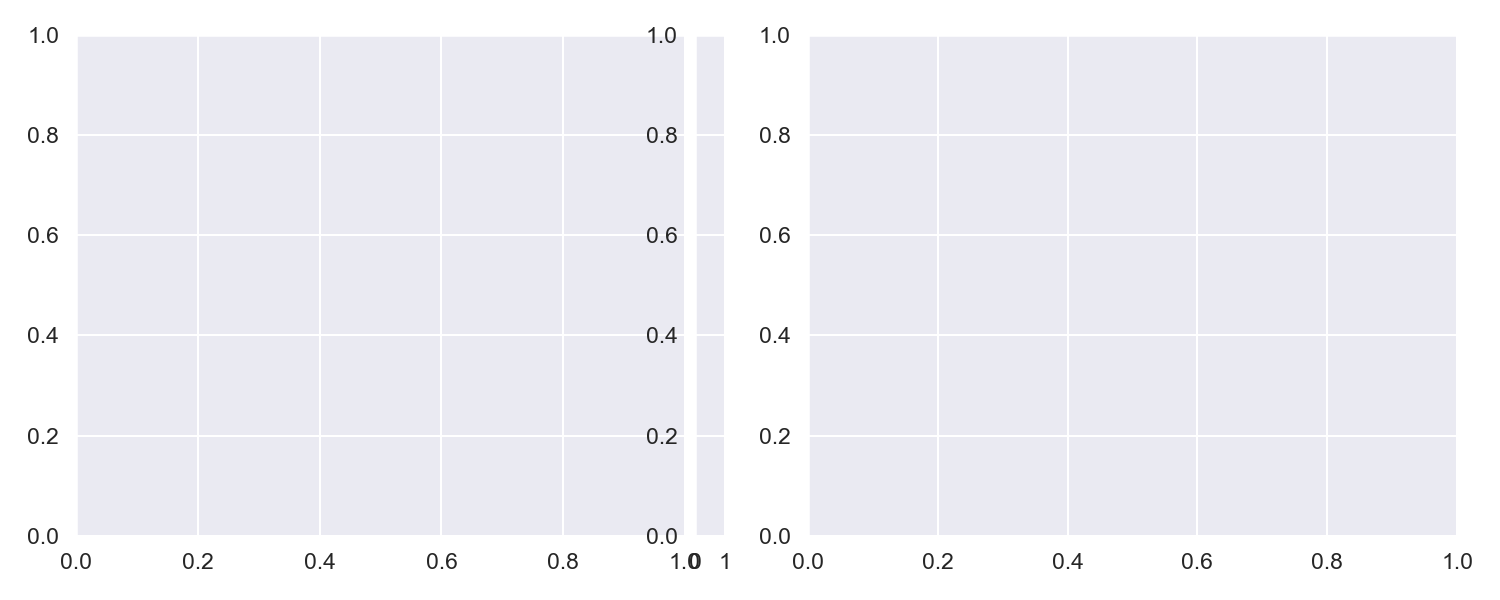

In [6]:
def get_single_image(fname, n, mask=None):
    imgs = fabio.open(fname)
    img = imgs.get_frame(n).data.astype(float)
    
    if mask is not None:
        img[mask == 1] = np.nan
        
    img[514:551, :] = np.nan
    img[0, 1029] = np.nan
        
    img[img > 1e8] = np.nan
    
    return img


def read_img(fname, flip=False, mask=None):
    fname = str(fname)
    _, file_extension = os.path.splitext(fname)
    
    if file_extension == '.raw': 
        try:
            arr = np.asarray(np.fromfile(fname, dtype='int32', sep=""), dtype=float)
            arr.shape = (195, 487)
        except:
            print("Error reading file: %s" % file)
            return None
    else:
        try:
            arr = (fabio.open(tiff_file).data).astype(float)
        except:
            print("Error reading file: %s" % file)
            return None
        
    if flip:
        arr = np.fliplr(arr)  #for the way mounted at BL2-1
    
    return arr        
    

def get_from_spec_file(fname, scan_number, cols=None, return_labels=False):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    if return_labels:
        return spec_scan.labels

    spec_data = {}
    for col in cols:
        spec_data[col] = spec_scan.data_column_by_name(col)

    spec_file.close()
    return spec_data


def get_spec_cols(fname, scan_number):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    spec_file.close()
    return spec_scan.labels


def get_spec_x_data(fname, scan_number):    
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]
    
    x_col = get_spec_x_col(fname, scan_number)
    x_data = spec_scan.data_column_by_name(x_col)
    
    spec_file.close()
    return x_col, x_data


def get_spec_scan_type(fname, scan_number):
    spec_file = SpecFile(str(fname))
    
    spec_scan = spec_file[scan_number-1]  
    spec_file.close()

    scan_hdr = spec_scan.scan_header_dict['S'].split()
    return scan_hdr[1]


def get_spec_x_col(fname, scan_number):
    spec_file = SpecFile(str(fname))
    
    spec_scan = spec_file[scan_number-1]  
    spec_file.close()

    scan_hdr = spec_scan.scan_header_dict['S'].split()
    x_col = scan_hdr[2]
    
    if scan_hdr[1] == 'hklscan':
        hkl_ranges = [float(scan_hdr[3]) - float(scan_hdr[2]),
                      float(scan_hdr[5]) - float(scan_hdr[4]),
                      float(scan_hdr[7]) - float(scan_hdr[6])]
    
        x_col = ['H', 'K', 'L'][np.nonzero(hkl_ranges)[0][0]]
   
    return x_col


def get_spec_scan_hdr(fname, scan_number):
    spec_file = SpecFile(str(fname))
    
    spec_scan = spec_file[scan_number-1]  
    spec_file.close()

    scan_hdr = spec_scan.scan_header_dict['S'].split()
    return scan_hdr
    

def get_mesh_scans(scans):
    mesh_scans = []
    for scan in scans.keys():
        fname, scan_number = scans[scan]['spec_fpath'], scans[scan]['scan_num']
        if get_spec_scan_type(fname, scan_number) == 'mesh':
            mesh_scans.append(scan)
    
    return mesh_scans


def get_roi_sums(scan, xlim=None, ylim=None):
    im_files = scans[scan]['img_fnames']
    if len(im_files) == 0:
        return None, None, None

    xlim = [0, -1] if xlim is None else xlim
    ylim = [0, -1] if ylim is None else ylim

    #xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    #ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    
    im_shape = read_img(im_files[0]).shape
    rows = [max(0, ylim[0]), min(im_shape[0], ylim[1])]
    cols = [max(0, xlim[0]), min(im_shape[1], xlim[1])]
    
    y_data = []
    for im_file in im_files:
        im_arr = read_img(im_file)
        y_data.append(np.nansum(im_arr[rows[0]:rows[1], cols[0]:cols[1]]))

    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    x_col, x_data = get_spec_x_data(spec_fpath, scan_num)

    return x_col, x_data, y_data


def create_roi_rectangle(ax):
    """
    Creates and returns a Rectangle patch for ROI selection.

    Args:
        ax: The Matplotlib axis to add the rectangle to.

    Returns:
        The Rectangle object.
    """
    rect = plt.Rectangle((0, 0), 1, 1, alpha=0.3, 
                         facecolor='white', edgecolor='white', zorder=100)
    ax.add_patch(rect)
    rect.set_visible(False)
    return rect


def show_raw_image(scan, n, vminmax, ax, cax):
    im_files = scans[scan]['img_fnames'] 
    n_ims = len(im_files)
    if n_ims == 0:
        ax.cla()
        ax.set_title(f'{scan}: No Images')
        return
        
    nimage_widget.max = n_ims - 1
    n = min(n, n_ims-1)
    nimage_widget.value = n
    
    im_file = im_files[n]
    im_arr = read_img(im_file)
    
    minmax = np.nanpercentile(im_arr, vminmax)
    i1 = ax.imshow(
        im_arr, cmap=cmap, origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
        )
    ax.set_xlabel('x [Pixels]')
    ax.set_ylabel('y [Pixels]')
    ax.set_title(f'{scan} [{n}/{n_ims-1}]')
    ax.grid(False)
    
    cb1 = plt.colorbar(i1, cax=cax, use_gridspec=True)


f2, (f2_ax1, f2_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f2_ax1)
f2_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f2.add_axes(f2_cax1)

nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

def plot_roi_sums(x_col, x_data, y_data):
    if overplot_button.description == 'Overplot':
        f2_ax2.cla()

    f2_ax2.plot(x_data, y_data, 'o-')
    if log_button.description == 'Linear':
        f2_ax2.set_yscale('log')
    f2_ax2.set_xlabel(f'{x_col}')
    
    return x_col, x_data, y_data
 

def update_roi(xlim=None, ylim=None):
    x_col, x_data, y_data = get_roi_sums(scan_widget.value, xlim, ylim)
    if x_col is not None:
        plot_roi_sums(x_col, x_data, y_data)
    else:
        f2_ax2.cla()

rect, RS = setup_roi_selection(f2_ax1, update_roi) 


clear_button = ipw.Button(description="Clear Plot")
def on_clear_button_clicked(b):
    f2_ax2.cla()
clear_button.on_click(on_clear_button_clicked)

overplot_button = ipw.Button(description="Overplot")
def on_overplot_button_clicked(b):
    if overplot_button.description == 'Overplot':
        overplot_button.description = 'No Overplot'
    else:
        overplot_button.description = 'Overplot'
overplot_button.on_click(on_overplot_button_clicked)

log_button = ipw.Button(description="Log")
def on_log_button_clicked(b):
    if log_button.description == 'Log':
        f2_ax2.set_yscale('log')
        log_button.description = 'Linear'
    else:
        f2_ax2.set_yscale('linear')
        log_button.description = 'Log'
log_button.on_click(on_log_button_clicked)


def plot_lscan_roi(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f2_ax1, f2_cax1)
    update_roi()

scan_list = line_scans
if len(line_scans) > 0:
    scan = scan_list[-1]
    scan_widget = ipw.Dropdown(options=scan_list, value=scan)
    
    interact(plot_lscan_roi, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget);
    display(ipw.HBox([clear_button, overplot_button, log_button]))



f4, (f4_ax1, f4_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f4_ax1)
f4_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax1)

divider = make_axes_locatable(f4_ax2)
f4_cax2 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax2)

mesh_scans = get_mesh_scans(scans)
scan = mesh_scans[0]

scan_widget = ipw.Dropdown(options=mesh_scans, value=scan)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

xlim, ylim = None, None   
gx, gy = None, None
xy_motors = []

def update_roi():
    global gx, gy
    roi_sums, gx, gy = get_roi_mesh(scan_widget.value)
    plot_mesh(roi_sums, gx, gy)

def get_roi_mesh(scan): #, xlim=None, ylim=None):
    global gx, gy, xy_motors, rect, xlim, ylim
    
    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    scan_hdr = get_spec_scan_hdr(spec_fpath, scan_num)
    xy_motors = [scan_hdr[2], scan_hdr[6]]
    
    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, xy_motors)
    gx, gy = spec_data[xy_motors[0]], spec_data[xy_motors[1]]

    bbox = rect.get_bbox()
    xlim = [int(np.round(i)) for i in [bbox.xmin, bbox.xmax]]
    ylim = [int(np.round(i)) for i in [bbox.ymin, bbox.ymax]]

    if (xlim[1] - xlim[0] <= 1) and (ylim[1] - ylim[0] <= 1):
        xlim, ylim = None, None

    _, _, roi_sums = get_roi_sums(scan, xlim, ylim)
    
    ngx, ngy = len(np.unique(gx)), len(np.unique(gy))
    roi_sums = np.array(roi_sums).reshape(ngy, ngx)

    return roi_sums, gx, gy


def plot_mesh(roi_sums, gx, gy):
    global xy_motors
    
    minmax = np.nanpercentile(roi_sums, vminmax_widget.value)
    i1 = f4_ax2.imshow(
        roi_sums, cmap=cmap, 
        extent=[gx[0], gx[-1], gy[0], gy[-1]], origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
    )
    f4_ax2.set_xlabel(f'{xy_motors[0]} [mm]', fontsize=14)
    f4_ax2.set_ylabel(f'{xy_motors[1]} [mm]', fontsize=14)
    f4_ax2.grid(False)
    
    plt.colorbar(i1, cax=f4_cax2, use_gridspec=True)


# Create a persistent rectangle patch (initially hidden)
rect = plt.Rectangle((0, 0), 1, 1, alpha=0.3, facecolor='white', edgecolor='white', zorder=100)
f4_ax1.add_patch(rect)
rect.set_visible(False)


def on_click(event):
    global gx, gy
    if event.inaxes == f4_ax2:
        x_data, y_data = event.xdata, event.ydata
        n = np.argmin(np.abs(gx - x_data) + np.abs(gy - y_data))
        show_raw_image(scan_widget.value, n, vminmax_widget.value, f4_ax1, f4_cax1)
f4_ax2.figure.canvas.mpl_connect('button_press_event', on_click) 
    

# --------  Adding Feedback and Persistence --------
# ec, er = None, None
def line_select_callback(eclick, erelease):
    # global xlim, ylim, ec, er
    if (eclick.inaxes != f4_ax1):
        return

    # ec, er = eclick, erelease
    
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    # Update ROI
    # xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    # ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    update_roi()#xlim, ylim)

    # Update the selected rectangle visualization
    rect.set_xy((min(x1, x2), min(y1, y2)))
    rect.set_width(abs(x1 - x2))
    rect.set_height(abs(y1 - y2))
    f4_ax1.figure.canvas.draw_idle()


# Create the RectangleSelector
RS = RectangleSelector(f4_ax1, line_select_callback,
                       useblit=True, button=[1],
                       minspanx=5, minspany=5, spancoords='pixels',
                       interactive=True)


def plot_roi_mesh(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f4_ax1, f4_cax1)

    roi_sums, gx, gy = get_roi_mesh(scan)
    plot_mesh(roi_sums, gx, gy)

    f4.tight_layout(pad=1, w_pad=1, h_pad=1)

interact(plot_roi_mesh, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget);

In [3]:
def setup_roi_selection(ax, update_roi): 
    """
    Sets up ROI selection functionality on a given axis.

    Args:
        ax: The Matplotlib axis for ROI selection.
    """
    rect = create_roi_rectangle(ax)
    
    # --------  Adding Feedback and Persistence --------
    def line_select_callback(eclick, erelease):
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
    
        # Update ROI
        xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
        ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
        if (xlim[1] - xlim[0] == 1) and (ylim[1] - ylim[0] == 1):
            xlim, ylim = None, None
    
        update_roi(xlim, ylim)
        
        # Update the selected rectangle visualization
        rect.set_xy((min(x1, x2), min(y1, y2)))
        rect.set_width(abs(x1 - x2))
        rect.set_height(abs(y1 - y2))
        #f2_ax1.figure.canvas.draw_idle()
        ax.figure.canvas.draw_idle()

    RS = RectangleSelector(ax, line_select_callback, 
                           useblit=True, button=[1],
                           minspanx=5, minspany=5, spancoords='pixels',
                           interactive=True)

    # Note: You might want to return 'rect' and 'RS' if you need them later.
    return rect, RS

## Paths

In [78]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_03_Porter/')
img_fpath = base_path.joinpath('images')

scans = OrderedDict()

spec_names_scan_nums = [
    ('align', [42]),
    ('EuV3Sb4', [14,46,57])
]

for spec_name, scan_nums in spec_names_scan_nums:
    spec_fpath = base_path.joinpath(spec_name, spec_name)
    for scan_num in scan_nums:
        scans[f'{spec_name}_scan{scan_num}'] = {
            'spec_fpath': spec_fpath,
            'scan_num': scan_num,
            'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}_*.raw'))) 
        }

all_scans = list(scans.keys())
mesh_scans = get_mesh_scans(scans)
line_scans = [scan for scan in all_scans if scan not in mesh_scans]

In [77]:
get_from_spec_file('EuV3Sb4', 43, cols=['crx'], return_labels=False)

SfErrFileOpen: File open error ( SpecFile )

### Show raw images, select and plot ROI sum

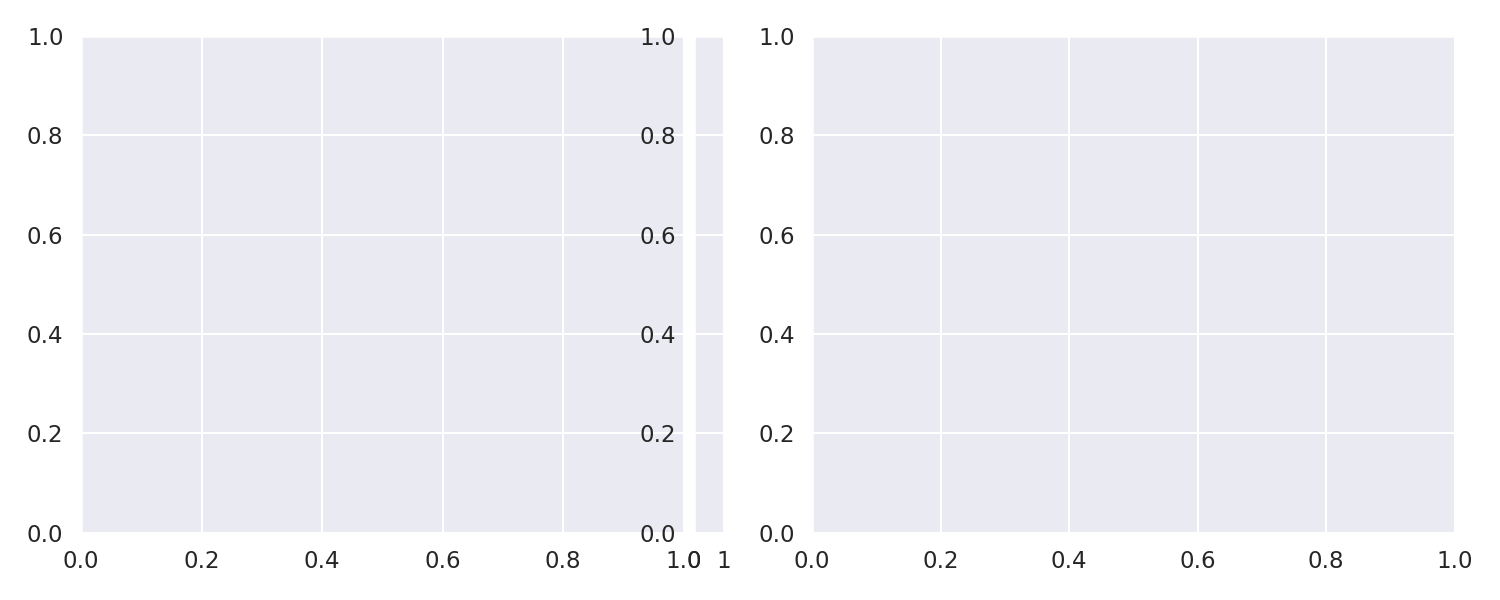

In [7]:
f2, (f2_ax1, f2_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f2_ax1)
f2_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f2.add_axes(f2_cax1)

nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

def plot_roi_sums(x_col, x_data, y_data):
    if overplot_button.description == 'Overplot':
        f2_ax2.cla()

    f2_ax2.plot(x_data, y_data, 'o-')
    if log_button.description == 'Linear':
        f2_ax2.set_yscale('log')
    f2_ax2.set_xlabel(f'{x_col}')
    
    return x_col, x_data, y_data
 

def update_roi(xlim=None, ylim=None):
    x_col, x_data, y_data = get_roi_sums(scan_widget.value, xlim, ylim)
    if x_col is not None:
        plot_roi_sums(x_col, x_data, y_data)
    else:
        f2_ax2.cla()

rect, RS = setup_roi_selection(f2_ax1, update_roi) 


clear_button = ipw.Button(description="Clear Plot")
def on_clear_button_clicked(b):
    f2_ax2.cla()
clear_button.on_click(on_clear_button_clicked)

overplot_button = ipw.Button(description="Overplot")
def on_overplot_button_clicked(b):
    if overplot_button.description == 'Overplot':
        overplot_button.description = 'No Overplot'
    else:
        overplot_button.description = 'Overplot'
overplot_button.on_click(on_overplot_button_clicked)

log_button = ipw.Button(description="Log")
def on_log_button_clicked(b):
    if log_button.description == 'Log':
        f2_ax2.set_yscale('log')
        log_button.description = 'Linear'
    else:
        f2_ax2.set_yscale('linear')
        log_button.description = 'Log'
log_button.on_click(on_log_button_clicked)


def plot_lscan_roi(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f2_ax1, f2_cax1)
    update_roi()

scan_list = line_scans
if len(line_scans) > 0:
    scan = scan_list[-1]
    scan_widget = ipw.Dropdown(options=scan_list, value=scan)
    
    interact(plot_lscan_roi, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget);
    display(ipw.HBox([clear_button, overplot_button, log_button]))

In [ ]:
# ... (other imports)
import ipywidgets as ipw

# ... (your configuration, helper functions)

# ---------------- Interactive Plotting Functions ---------------

def plot_lscan_roi(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f2_ax1, f2_cax1)
    update_roi()

def plot_roi_mesh(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f4_ax1, f4_cax1)
    update_roi()

# ---------------- User Interface Setup (Widgets) ---------------

# ... (Create figures f2, f4, axes etc.)

# Widgets for line scan interaction
scan_list = line_scans if line_scans else []  # Get your line scan list
scan_widget = ipw.Dropdown(options=scan_list, value=scan_list[-1] if scan_list else None)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

# Widgets for mesh scan interaction
mesh_scans = get_mesh_scans(scans)
scan_widget2 = ipw.Dropdown(options=mesh_scans, value=mesh_scans[0])

# ... (Other widgets if needed: clear_button, overplot_button, etc.)

# ----------------------- Interactive Linking ------------------------

ipw.interact(plot_lscan_roi, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget)
ipw.interact(plot_roi_mesh, scan=scan_widget2, n=nimage_widget, vminmax=vminmax_widget)

# ... (If you have more interactive elements, add them here)


In [ ]:
# ... (other imports)
import ipywidgets as ipw

# ... (your configuration, helper functions)

# ---------------- Interactive Plotting Functions ---------------

def plot_lscan_roi(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f2_ax1, f2_cax1)
    update_roi()

def plot_roi_mesh(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f4_ax1, f4_cax1)
    update_roi()

# ---------------- User Interface Setup (Widgets) ---------------

# ... (Create figures f2, f4, axes etc.)

# Widgets for line scan interaction
scan_list = line_scans if line_scans else []  # Get your line scan list
scan_widget = ipw.Dropdown(options=scan_list, value=scan_list[-1] if scan_list else None)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

# Widgets for mesh scan interaction
mesh_scans = get_mesh_scans(scans)
scan_widget2 = ipw.Dropdown(options=mesh_scans, value=mesh_scans[0])

# ... (Other widgets if needed: clear_button, overplot_button, etc.)

# ----------------------- Interactive Linking ------------------------

ipw.interact(plot_lscan_roi, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget)
ipw.interact(plot_roi_mesh, scan=scan_widget2, n=nimage_widget, vminmax=vminmax_widget)

# ... (If you have more interactive elements, add them here)


### Show raw images

interactive(children=(Dropdown(description='scan', index=1, options=('align_scan42', 'EuV3Sb4_scan14'), value=…

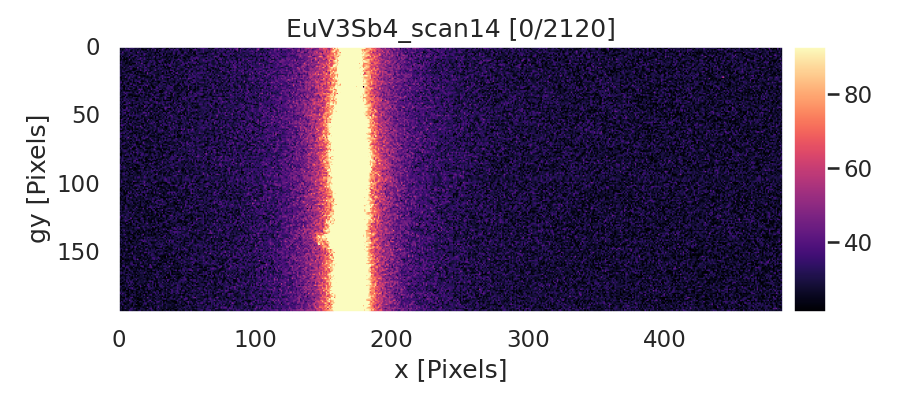

In [27]:
f1, f1_ax1 = plt.subplots(figsize=(9, 4), layout='tight')

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

scan = all_scans[-1]
scan_widget = ipw.Dropdown(options=all_scans, value=scan)

nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

interact(show_raw_image, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget, ax=fixed(f1_ax1), cax=fixed(f1_cax1));

### Plot Mesh with predefined ROIs

interactive(children=(Dropdown(description='scan', index=3, options=('align_scan42', 'EuV3Sb4_scan14', 'EuV3Sb…

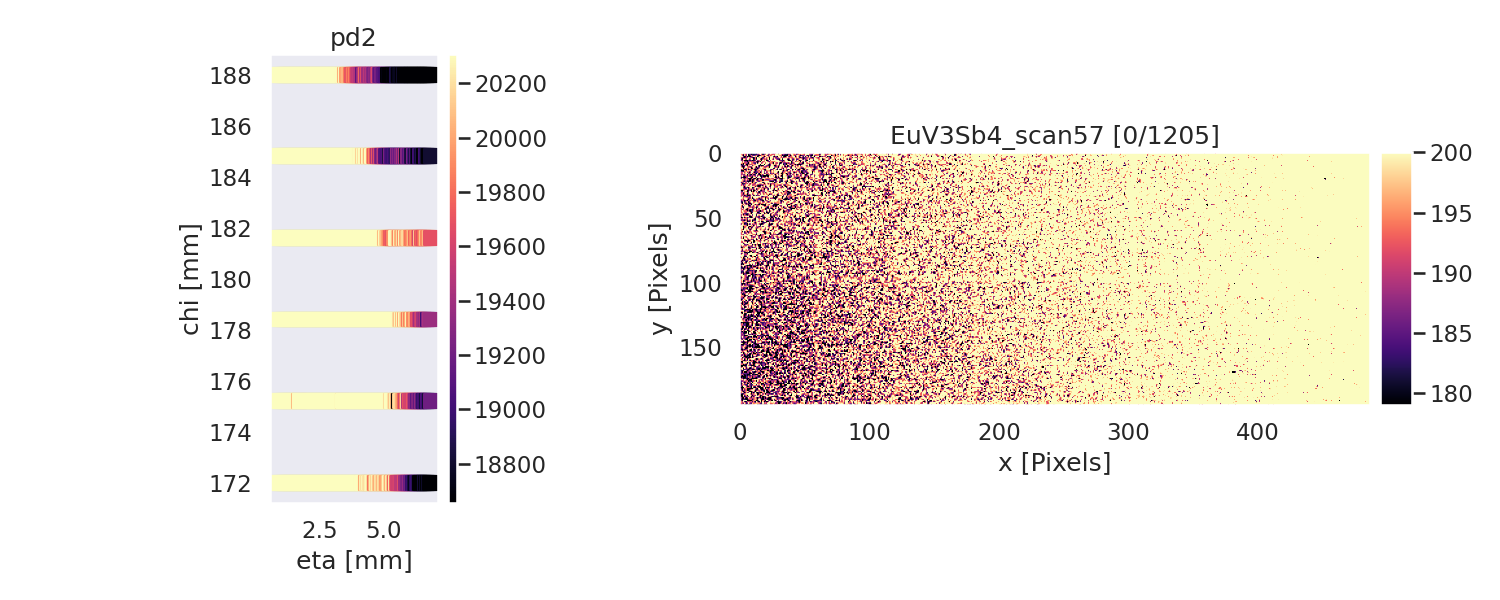

In [82]:
for spec_name, scan_nums in spec_names_scan_nums:
    spec_fpath = base_path.joinpath(spec_name, spec_name)
    for scan_num in scan_nums:
        scans[f'{spec_name}_scan{scan_num}'] = {
            'spec_fpath': spec_fpath,
            'scan_num': scan_num,
            'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}_*.raw'))) 
        }

all_scans = list(scans.keys())
mesh_scans = get_mesh_scans(scans)
line_scans = [scan for scan in all_scans if scan not in mesh_scans]

f3, (f3_ax1, f3_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f3_ax1)
f3_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f3.add_axes(f3_cax1)

divider = make_axes_locatable(f3_ax2)
f3_cax2 = divider.append_axes("right", size="5%", pad=0.1)
f3.add_axes(f3_cax2)

mesh_scans = get_mesh_scans(scans)
scan = mesh_scans[-1]

scan_widget = ipw.Dropdown(options=mesh_scans, value=scan)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 35], step=0.5)

spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
rois = get_spec_cols(spec_fpath, scan_num)
rois = [roi for roi in rois if 'pd' in roi]


def on_click(event):
    global gx, gy
    if event.inaxes == f3_ax1:
        x_data, y_data = event.xdata, event.ydata
        n = np.argmin(np.abs(gx - x_data) + np.abs(gy - y_data))
        show_raw_image(scan_widget.value, n, vminmax_widget.value, f3_ax2, f3_cax2)
f3.canvas.mpl_connect('button_press_event', on_click) 


gx, gy = None, None
def show_mesh_and_raw(scan, roi, vminmax, ms=50):
    global gx, gy

    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']

    scan_hdr = get_spec_scan_hdr(spec_fpath, scan_num)
    xy_motors = [scan_hdr[2], scan_hdr[6]]
    
    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, [xy_motors[0], xy_motors[1], roi])
    gx, gy, roi_sums = spec_data[xy_motors[0]], spec_data[xy_motors[1]], spec_data[roi]

    minmax = np.nanpercentile(roi_sums, vminmax)
    f3_ax1.cla(); f3_cax1.cla()
    i1 = f3_ax1.scatter(gx, gy, c=roi_sums, cmap=cmap, s=ms, marker='s',
                        vmin=minmax[0], vmax=minmax[1])
    f3_ax1.set_aspect('equal')
    f3_ax1.set_xlabel(f'{xy_motors[0]} [mm]')
    f3_ax1.set_ylabel(f'{xy_motors[1]} [mm]')
    f3_ax1.set_title(f'{roi}')
    f3_ax1.grid(False)
    
    plt.colorbar(i1, cax=f3_cax1, use_gridspec=True)    

    show_raw_image(scan, 0, vminmax, f3_ax2, f3_cax2)


interact(show_mesh_and_raw, scan=scan_widget, roi=ipw.Dropdown(options=rois, value='pd2'),
         vminmax=vminmax_widget, ms=ipw.IntSlider(min=10, max=600, value=100, step=5, description='marker size'));

## Plot mesh for selected ROI

interactive(children=(Dropdown(description='scan', options=('align_scan42', 'EuV3Sb4_scan14'), value='align_sc…

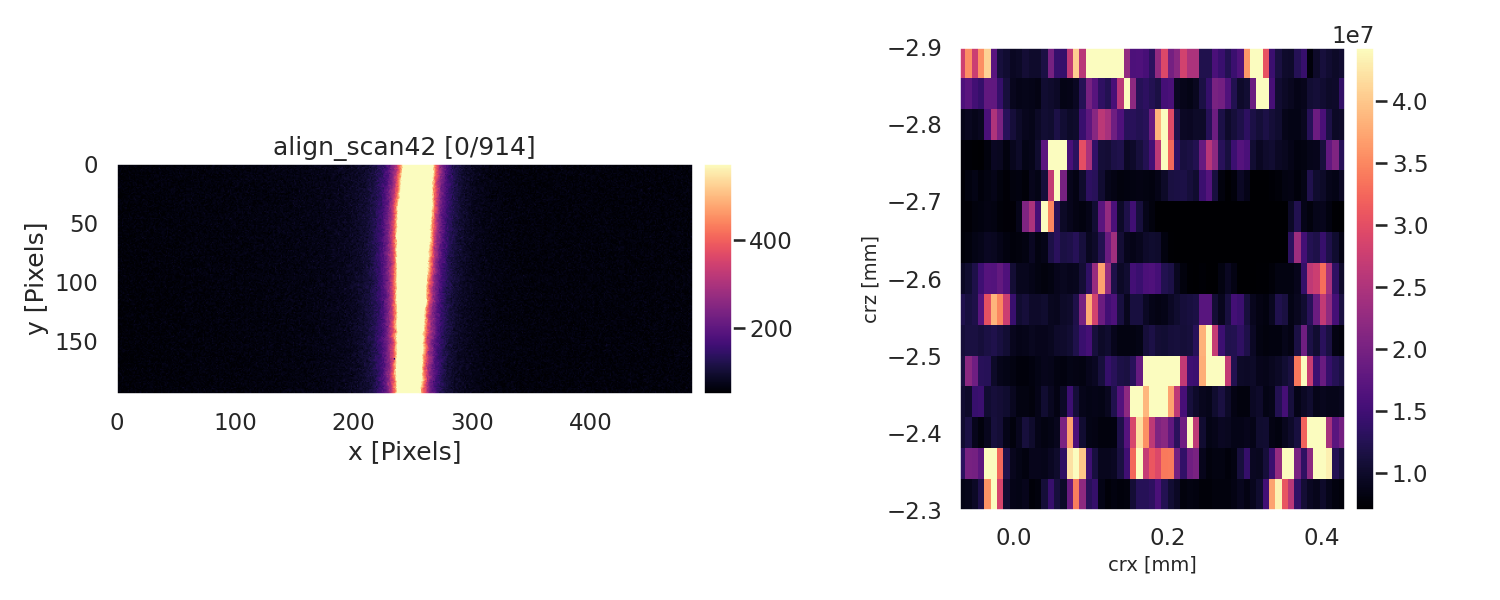

In [70]:
f4, (f4_ax1, f4_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f4_ax1)
f4_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax1)

divider = make_axes_locatable(f4_ax2)
f4_cax2 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax2)

mesh_scans = get_mesh_scans(scans)
scan = mesh_scans[0]

scan_widget = ipw.Dropdown(options=mesh_scans, value=scan)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

xlim, ylim = None, None   
gx, gy = None, None
xy_motors = []

def update_roi():
    global gx, gy
    roi_sums, gx, gy = get_roi_mesh(scan_widget.value)
    plot_mesh(roi_sums, gx, gy)

def get_roi_mesh(scan): #, xlim=None, ylim=None):
    global gx, gy, xy_motors, rect, xlim, ylim
    
    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    scan_hdr = get_spec_scan_hdr(spec_fpath, scan_num)
    xy_motors = [scan_hdr[2], scan_hdr[6]]
    
    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, xy_motors)
    gx, gy = spec_data[xy_motors[0]], spec_data[xy_motors[1]]

    bbox = rect.get_bbox()
    xlim = [int(np.round(i)) for i in [bbox.xmin, bbox.xmax]]
    ylim = [int(np.round(i)) for i in [bbox.ymin, bbox.ymax]]

    if (xlim[1] - xlim[0] <= 1) and (ylim[1] - ylim[0] <= 1):
        xlim, ylim = None, None

    _, _, roi_sums = get_roi_sums(scan, xlim, ylim)
    
    ngx, ngy = len(np.unique(gx)), len(np.unique(gy))
    roi_sums = np.array(roi_sums).reshape(ngy, ngx)

    return roi_sums, gx, gy


def plot_mesh(roi_sums, gx, gy):
    global xy_motors
    
    minmax = np.nanpercentile(roi_sums, vminmax_widget.value)
    i1 = f4_ax2.imshow(
        roi_sums, cmap=cmap, 
        extent=[gx[0], gx[-1], gy[0], gy[-1]], origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
    )
    f4_ax2.set_xlabel(f'{xy_motors[0]} [mm]', fontsize=14)
    f4_ax2.set_ylabel(f'{xy_motors[1]} [mm]', fontsize=14)
    f4_ax2.grid(False)
    
    plt.colorbar(i1, cax=f4_cax2, use_gridspec=True)


# Create a persistent rectangle patch (initially hidden)
rect = plt.Rectangle((0, 0), 1, 1, alpha=0.3, facecolor='white', edgecolor='white', zorder=100)
f4_ax1.add_patch(rect)
rect.set_visible(False)


def on_click(event):
    global gx, gy
    if event.inaxes == f4_ax2:
        x_data, y_data = event.xdata, event.ydata
        n = np.argmin(np.abs(gx - x_data) + np.abs(gy - y_data))
        show_raw_image(scan_widget.value, n, vminmax_widget.value, f4_ax1, f4_cax1)
f4_ax2.figure.canvas.mpl_connect('button_press_event', on_click) 
    

# --------  Adding Feedback and Persistence --------
# ec, er = None, None
def line_select_callback(eclick, erelease):
    # global xlim, ylim, ec, er
    if (eclick.inaxes != f4_ax1):
        return

    # ec, er = eclick, erelease
    
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    # Update ROI
    # xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    # ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    update_roi()#xlim, ylim)

    # Update the selected rectangle visualization
    rect.set_xy((min(x1, x2), min(y1, y2)))
    rect.set_width(abs(x1 - x2))
    rect.set_height(abs(y1 - y2))
    f4_ax1.figure.canvas.draw_idle()


# Create the RectangleSelector
RS = RectangleSelector(f4_ax1, line_select_callback,
                       useblit=True, button=[1],
                       minspanx=5, minspany=5, spancoords='pixels',
                       interactive=True)


def plot_roi_mesh(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f4_ax1, f4_cax1)

    roi_sums, gx, gy = get_roi_mesh(scan)
    plot_mesh(roi_sums, gx, gy)

    f4.tight_layout(pad=1, w_pad=1, h_pad=1)

interact(plot_roi_mesh, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget);

interactive(children=(Dropdown(description='scan', options=('align_scan42', 'EuV3Sb4_scan14'), value='align_sc…

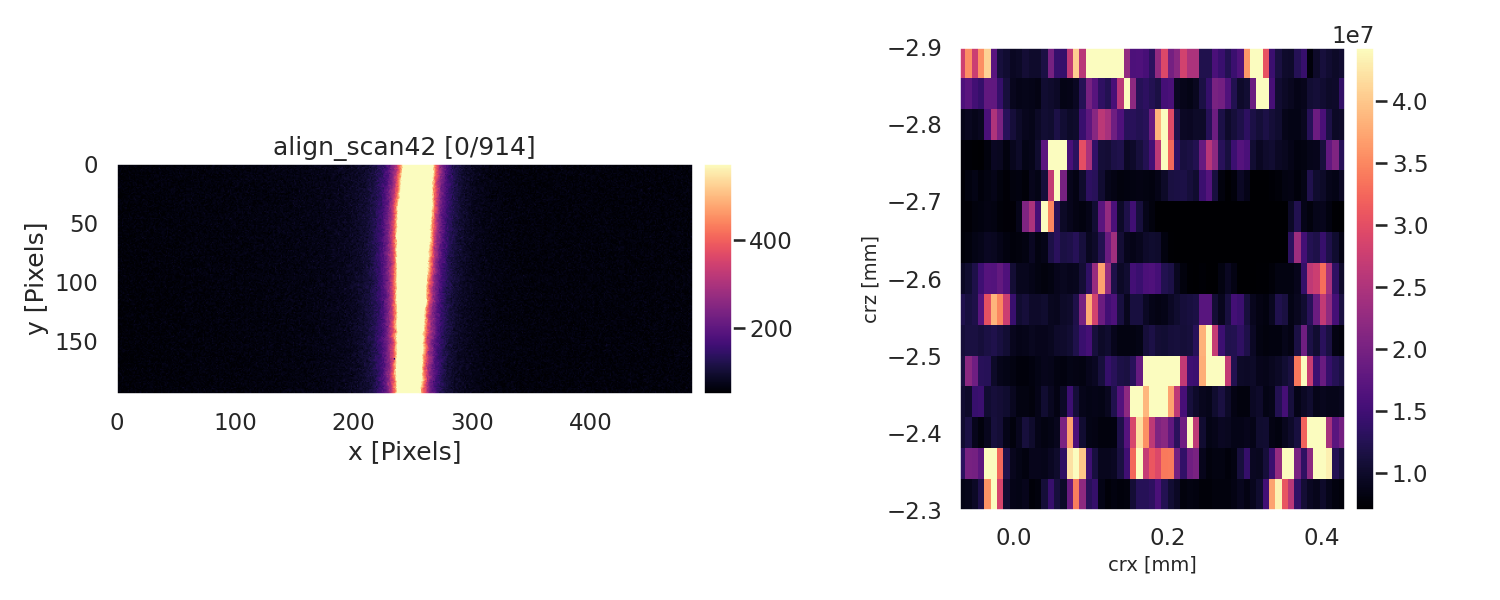

In [46]:
xy_motors = ['crx', 'crz']

f4, (f4_ax1, f4_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f4_ax1)
f4_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax1)

divider = make_axes_locatable(f4_ax2)
f4_cax2 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax2)

mesh_scans = get_mesh_scans(scans)
scan = mesh_scans[0]

scan_widget = ipw.Dropdown(options=mesh_scans, value=scan)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

xlim, ylim = None, None   
def update_roi(xlim, ylim):
    global rect
    
    if (rect.get_width() == 0) and (rect.get_height() == 0):
        xlim, ylim = None, None
    bbox = rect.get_bbox()
    
    roi_sums, gx, gy = get_roi_mesh(scan_widget.value, xlim, ylim)
    plot_mesh(roi_sums, gx, gy)


gx, gy = None, None
xy_motors = []
def get_roi_mesh(scan, xlim=None, ylim=None):
    global gx, gy, xy_motors
    
    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    scan_hdr = get_spec_scan_hdr(spec_fpath, scan_num)
    xy_motors = [scan_hdr[2], scan_hdr[6]]
    

    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, xy_motors)
    gx, gy = spec_data[xy_motors[0]], spec_data[xy_motors[1]]
    _, _, roi_sums = get_roi_sums(scan, xlim, ylim)
    
    ngx, ngy = len(np.unique(gx)), len(np.unique(gy))
    roi_sums = np.array(roi_sums).reshape(ngy, ngx)

    return roi_sums, gx, gy


def plot_mesh(roi_sums, gx, gy):
    global xy_motors
    
    minmax = np.nanpercentile(roi_sums, vminmax_widget.value)
    i1 = f4_ax2.imshow(
        roi_sums, cmap=cmap, 
        extent=[gx[0], gx[-1], gy[0], gy[-1]], origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
    )
    f4_ax2.set_xlabel(f'{xy_motors[0]} [mm]', fontsize=14)
    f4_ax2.set_ylabel(f'{xy_motors[1]} [mm]', fontsize=14)
    f4_ax2.grid(False)
    
    plt.colorbar(i1, cax=f4_cax2, use_gridspec=True)


# Create a persistent rectangle patch (initially hidden)
rect = plt.Rectangle((0, 0), 1, 1, alpha=0.3, facecolor='white', edgecolor='white', zorder=100)
f4_ax1.add_patch(rect)
rect.set_visible(False)


def on_click(event):
    global gx, gy
    if event.inaxes == f4_ax2:
        x_data, y_data = event.xdata, event.ydata
        n = np.argmin(np.abs(gx - x_data) + np.abs(gy - y_data))
        show_raw_image(scan_widget.value, n, vminmax_widget.value, f4_ax1, f4_cax1)
f4.canvas.mpl_connect('button_press_event', on_click) 
    

# --------  Adding Feedback and Persistence --------
def line_select_callback(eclick, erelease):
    global xlim, ylim
    if eclick.inaxes != f4_ax1:
        return
        
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    # Update ROI
    xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    update_roi(xlim, ylim)
    print(xlim, ylim)

    # Update the selected rectangle visualization
    rect.set_xy((min(x1, x2), min(y1, y2)))
    rect.set_width(abs(x1 - x2))
    rect.set_height(abs(y1 - y2))
    f4_ax1.figure.canvas.draw_idle()


# Create the RectangleSelector
RS = RectangleSelector(f4_ax1, line_select_callback,
                       useblit=True, button=[1],
                       minspanx=5, minspany=5, spancoords='pixels',
                       interactive=True)


def plot_roi_mesh(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f4_ax1, f4_cax1)

    roi_sums, gx, gy = get_roi_mesh(scan)
    plot_mesh(roi_sums, gx, gy)

    f4.tight_layout(pad=1, w_pad=1, h_pad=1)

interact(plot_roi_mesh, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget);

In [69]:
print(xlim, ylim, rect.get_bbox())

bbox = rect.get_bbox()
xl = [int(np.round(i)) for i in [bbox.xmin, bbox.xmax]]
yl = [int(np.round(i)) for i in [bbox.ymin, bbox.ymax]]

#x1 = [int(min(x1, x2)), int(max(x1, x2)) + 1]
#y1 = [int(min(y1, y2)), int(max(y1, y2)) + 1]

print(xl, yl, gx, gy)

[198, 251] [43, 95] Bbox(x0=197.71666267350744, y0=43.095859943113396, x1=250.86502124104484, y1=95.40059377148356)
[198, 251] [43, 95] [-0.070035 -0.06164  -0.05336  -0.044965 -0.036685 -0.02829  -0.02001
 -0.011615 -0.003335  0.004945  0.01334   0.02162   0.030015  0.038295
  0.04669   0.05497   0.063365  0.071645  0.08004   0.08832   0.096715
  0.104995  0.11339   0.12167   0.12995   0.138345  0.146625  0.15502
  0.1633    0.171695  0.179975  0.18837   0.19665   0.205045  0.213325
  0.22172   0.23      0.23828   0.246675  0.254955  0.26335   0.27163
  0.280025  0.288305  0.2967    0.30498   0.313375  0.321655  0.33005
  0.33833   0.34661   0.355005  0.363285  0.37168   0.37996   0.388355
  0.396635  0.40503   0.41331   0.421705  0.429985 -0.070035 -0.06164
 -0.05336  -0.044965 -0.036685 -0.02829  -0.02001  -0.011615 -0.003335
  0.004945  0.01334   0.02162   0.030015  0.038295  0.04669   0.05497
  0.063365  0.071645  0.08004   0.08832   0.096715  0.104995  0.11339
  0.12167   0.12995

[0, 1] [0, 1] Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)
[0, 1] [0, 1]


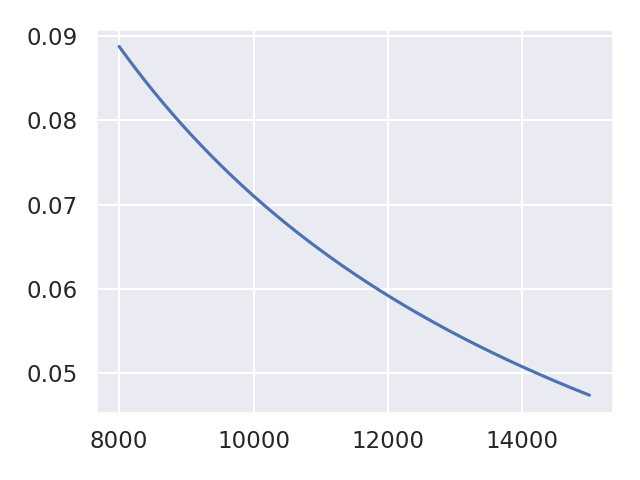

In [85]:
E = np.arange(8000, 15001)

def get_theta(En):
    return np.arcsin(12.398/E)

theta = np.arcsin(12.398/E)

plt.figure()
plt.plot(E, theta*180/np.pi)
plt.tight_layout()

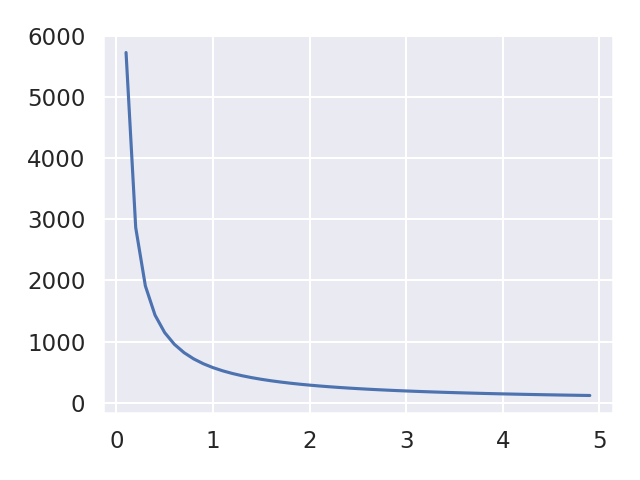

In [100]:
theta = np.arange(0.1, 5, 0.1) * np.pi/180

plt.figure()
plt.plot(theta * 180/np.pi, 10/np.sin(theta), '-')
plt.tight_layout()

In [92]:
10/np.sin(0.5*np.pi/180)

1145.9301348013032

In [193]:
sf, sn = scans['align_scan162']['spec_fpath'], scans['align_scan162']['scan_num']

specf = SpecFile(str(sf))[sn-1]

scan_hdr = specf.scan_header_dict['S'].split()
scan_hdr

hkl_ranges = {}
if scan_hdr[1] == 'hklscan':
    hkl_ranges = [np.round(float(scan_hdr[3]) - float(scan_hdr[2]), 1),
                  np.round(float(scan_hdr[5]) - float(scan_hdr[4]), 1),
                  np.round(float(scan_hdr[7]) - float(scan_hdr[6]), 1)]

['H', 'K', 'L'][np.nonzero(hkl_ranges)[0][0]]
#specf.data_column_by_name('K')

'L'

In [192]:
np.nonzero(hkl_ranges)[0][0]

2

In [166]:
scan_hdr = specf.scan_header_dict['S'].split()
scan_hdr

hkl_ranges = {}
if scan_hdr[1] == 'hklscan':
    hkl_ranges = [float(scan_hdr[3]) - float(scan_hdr[2]),
                  float(scan_hdr[5]) - float(scan_hdr[4]),
                  float(scan_hdr[7]) - float(scan_hdr[6])]

['H', 'K', 'L'][hkl_ranges != 0]
specf.data_column_by_name('H')

array([-1.536862e-07, -1.536862e-07, -1.536862e-07, -1.536862e-07,
       -1.536862e-07, -1.536862e-07, -1.536862e-07, -1.536862e-07,
       -1.536862e-07, -1.536862e-07, -1.536862e-07, -1.536862e-07,
       -1.536862e-07, -1.536862e-07, -1.536862e-07, -1.536862e-07,
       -1.536862e-07, -1.536862e-07, -1.536862e-07, -1.536862e-07,
       -1.536862e-07])

In [167]:
    hkl_ranges['H'] = [float(scan_hdr[2]), float(scan_hdr[3])]
    hkl_ranges['K'] = [float(scan_hdr[4]), float(scan_hdr[5])]
    hkl_ranges['L'] = [float(scan_hdr[6]), float(scan_hdr[7])]


x_col = hkl_ranges[]

SyntaxError: invalid syntax (514359016.py, line 6)

NameError: name 'line_scans' is not defined

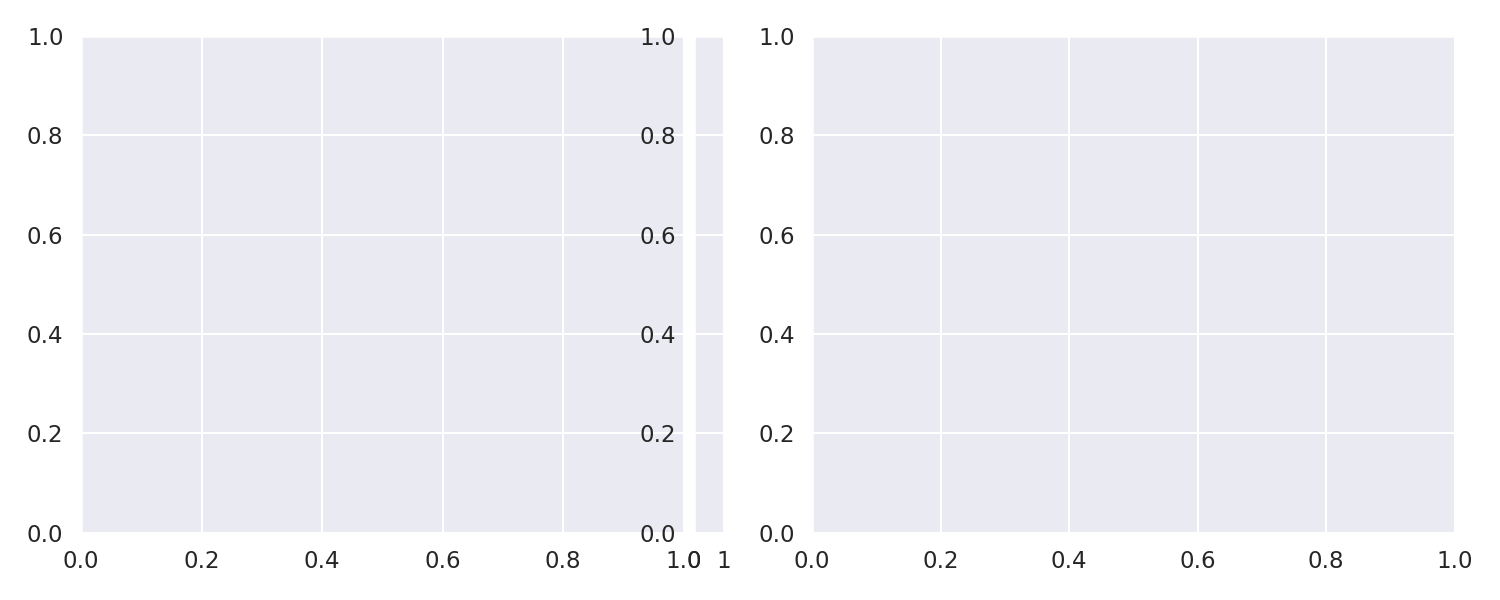

In [14]:
f2, (f2_ax1, f2_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f2_ax1)
f2_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f2.add_axes(f2_cax1)

scan_list = line_scans
scan = scan_list[0]
scan_widget = ipw.Dropdown(options=scan_list, value=scan)

nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)


def plot_roi_sums(x_col, x_data, y_data):
    if overplot_button.description == 'Overplot':
        f2_ax2.cla()

    f2_ax2.plot(x_data, y_data, 'o-')
    if log_button.description == 'Linear':
        f2_ax2.set_yscale('log')
    f2_ax2.set_xlabel(f'{x_col}')
    
    return x_col, x_data, y_data
 

def update_roi(xlim=None, ylim=None):
    x_col, x_data, y_data = get_roi_sums(scan_widget.value, xlim, ylim)
    if x_col is not None:
        plot_roi_sums(x_col, x_data, y_data)
    else:
        f2_ax2.cla()


# Create a persistent rectangle patch (initially hidden)
# rect = create_roi_rectangle(f2_ax1)


# --------  Adding Feedback and Persistence --------
def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    # Update ROI
    xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    if (xlim[1] - xlim[0] == 1) and (ylim[1] - ylim[0] == 1):
        xlim, ylim = None, None

    update_roi(xlim, ylim)
    
    # Update the selected rectangle visualization
    rect.set_xy((min(x1, x2), min(y1, y2)))
    rect.set_width(abs(x1 - x2))
    rect.set_height(abs(y1 - y2))
    #f2_ax1.figure.canvas.draw_idle()
    ax.figure.canvas.draw_idle()

# # Create the RectangleSelector
# RS = RectangleSelector(f2_ax1, line_select_callback, 
#                        useblit=True, button=[1],
#                        minspanx=5, minspany=5, spancoords='pixels',
#                        interactive=True)

rect, RS = setup_roi_selection(f2_ax1) 


clear_button = ipw.Button(description="Clear Plot")
def on_clear_button_clicked(b):
    f2_ax2.cla()
clear_button.on_click(on_clear_button_clicked)

overplot_button = ipw.Button(description="Overplot")
def on_overplot_button_clicked(b):
    if overplot_button.description == 'Overplot':
        overplot_button.description = 'No Overplot'
    else:
        overplot_button.description = 'Overplot'
overplot_button.on_click(on_overplot_button_clicked)

log_button = ipw.Button(description="Log")
def on_log_button_clicked(b):
    if log_button.description == 'Log':
        f2_ax2.set_yscale('log')
        log_button.description = 'Linear'
    else:
        f2_ax2.set_yscale('linear')
        log_button.description = 'Log'
log_button.on_click(on_log_button_clicked)


def plot_lscan_roi(scan, n, vminmax):
    show_raw_image(scan, n, vminmax, f2_ax1, f2_cax1)
    update_roi()

interact(plot_lscan_roi, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget);
display(ipw.HBox([clear_button, overplot_button, log_button]))

In [ ]:
f2, (f2_ax1, f2_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f2_ax1)
f2_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f2.add_axes(f2_cax1)
fig, ax1, cax1, ax2 = f2, f2_ax1, f2_cax1, f2_ax2

scan_list = line_scans
if len(scan_list) > 0: 
        
    scan = scan_list[0]
    scan_widget = ipw.Dropdown(options=scan_list, value=scan)
    
    nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
    vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)
    
    xlim, ylim = None, None
    update_ROI_button = ipw.Button(description="Update ROI")
    def on_update_ROI_button_clicked(b):
        global xlim, ylim
        xlim, ylim = ax1.get_xbound(), ax1.get_ybound()
        xlim = [int(x.round()) for x in xlim]
        ylim = [int(y.round()) for y in ylim]
    
        scan = scan_widget.value
        plot_roi_sums(scan, xlim, ylim)
    update_ROI_button.on_click(on_update_ROI_button_clicked)
    
  
    clear_button = ipw.Button(description="Clear Plot")
    def on_clear_button_clicked(b):
        ax2.cla()
    clear_button.on_click(on_clear_button_clicked)
    
  
    overplot_button = ipw.Button(description="Overplot")
    def on_overplot_button_clicked(b):
        if overplot_button.description == 'Overplot':
            overplot_button.description = 'No Overplot'
        else:
            overplot_button.description = 'Overplot'
    overplot_button.on_click(on_overplot_button_clicked)
    

    log_button = ipw.Button(description="Log")
    def on_log_button_clicked(b):
        if log_button.description == 'Log':
            ax2.set_yscale('log')
            log_button.description = 'Linear'
        else:
            ax2.set_yscale('linear')
            log_button.description = 'Log'
    log_button.on_click(on_log_button_clicked)
    
    
    def plot_roi_sums(scan, xlim=None, ylim=None):
        if overplot_button.description == 'Overplot':
            ax2.cla()

        x_col, x_data, y_data = get_roi_sums(scan, xlim, ylim)

        ax2.plot(x_data, y_data, 'o-')
        if log_button.description == 'Linear':
            ax2.set_yscale('log')
        ax2.set_xlabel(f'{x_col}')
        
        return x_col, x_data, y_data
     
    def plot_lscan_roi(scan, n, vminmax):
        show_raw_image(scan, n, vminmax, f2_ax1, f2_cax1)
        plot_roi_sums(scan, xlim, ylim)

    interact(plot_lscan_roi, scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget);
    display(ipw.HBox([update_ROI_button, clear_button, overplot_button, log_button]))

In [ ]:
f2, (f2_ax1, f2_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f2_ax1)
f2_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f2.add_axes(f2_cax1)
fig, ax1, cax1, ax2 = f2, f2_ax1, f2_cax1, f2_ax2

scan_list = line_scans
if len(scan_list) > 0: 
        
    scan = scan_list[0]
    scan_widget = ipw.Dropdown(options=scan_list, value=scan)
    
    nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
    vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)
    
    xlim, ylim = None, None
    update_ROI_button = ipw.Button(description="Update ROI")
    def on_update_ROI_button_clicked(b):
        global xlim, ylim
        xlim, ylim = ax1.get_xbound(), ax1.get_ybound()
        xlim = [int(x.round()) for x in xlim]
        ylim = [int(y.round()) for y in ylim]
    
        scan = scan_widget.value
        plot_roi_sums(scan, xlim, ylim)
    update_ROI_button.on_click(on_update_ROI_button_clicked)
    
  
    clear_button = ipw.Button(description="Clear Plot")
    def on_clear_button_clicked(b):
        ax2.cla()
    clear_button.on_click(on_clear_button_clicked)
    
  
    overplot_button = ipw.Button(description="Overplot")
    def on_overplot_button_clicked(b):
        if overplot_button.description == 'Overplot':
            overplot_button.description = 'No Overplot'
        else:
            overplot_button.description = 'Overplot'
    overplot_button.on_click(on_overplot_button_clicked)
    

    log_button = ipw.Button(description="Log")
    def on_log_button_clicked(b):
        if log_button.description == 'Log':
            ax2.set_yscale('log')
            log_button.description = 'Linear'
        else:
            ax2.set_yscale('linear')
            log_button.description = 'Log'
    log_button.on_click(on_log_button_clicked)
    
    
    def plot_roi_sums(scan, xlim=None, ylim=None):
        if overplot_button.description == 'Overplot':
            ax2.cla()

        x_col, x_data, y_data = get_roi_sums(scan, xlim, ylim)

        ax2.plot(x_data, y_data, 'o-')
        if log_button.description == 'Linear':
            ax2.set_yscale('log')
        ax2.set_xlabel(f'{x_col}')
        
        return x_col, x_data, y_data
     
    
    @interact(
        scan=scan_widget,
        n=nimage_widget,
        vminmax=vminmax_widget,
    )
    def show_raw_image(scan, n, vminmax):#, overplot):
        ax1.cla; cax1.cla()
    
        im_files = scans[scan]['img_fnames'] 
        n_ims = len(im_files)
        if n_ims == 0:
            ax1.cla()
            ax1.set_title(f'{scan}: No Images')
            return
            
        nimage_widget.max = n_ims - 1
        n = min(n, n_ims-1)
        nimage_widget.value = n
        
        im_file = im_files[n]
        im_arr = read_img(im_file)
        
        minmax = np.nanpercentile(im_arr, vminmax)
        i1 = ax1.imshow(
            im_arr, cmap='rocket', origin='upper',
            vmin=minmax[0], vmax=minmax[1], snap=False
            )
        ax1.set_xlabel('x [Pixels]', fontsize=14)
        ax1.set_ylabel('gy [Pixels]', fontsize=14)
        ax1.set_title(f'{scan} [{n}]')
        ax1.grid(False)
        
        cb1 = plt.colorbar(i1, cax=cax1, use_gridspec=True)
    
        plot_roi_sums(scan, xlim, ylim)
    
    display(ipw.HBox([update_ROI_button, clear_button, overplot_button, log_button]))

In [ ]:
f3, f3_ax1 = plt.subplots(figsize=(8, 5), layout='tight')

divider = make_axes_locatable(f3_ax1)
f3_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f3.add_axes(f3_cax1)
fig, ax1, cax1 = f3, f3_ax1, f3_cax1

mesh_scans = get_mesh_scans(scans)
scan = mesh_scans[-1]

scan_widget = ipw.Dropdown(options=mesh_scans, value=scan)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
rois = get_spec_cols(spec_fpath, scan_num)
rois = [roi for roi in rois if 'pd' in roi]

x_pixel, y_pixel, e = None, None, None
x_data, y_data = None, None
def on_click(event):
    global x_pixel, y_pixel, e, x_data, y_data
    if event.inaxes == f3_ax1:  # Check if click is within the desired axis
        x_data, y_data = event.xdata, event.ydata
        ax_transform = f3_ax1.transAxes 
        x_pixel, y_pixel = ax_transform.transform((x_data, y_data))
        print(f'x: {x}, y: {y}')  # Do something with the coordinates

        f3_ax1.set_title(f'{x_pixel:.1f}, {y_pixel:.1f}')
        f3_ax1.set_title(f'{x_data:.1f}, {y_data:.1f}')

f3.canvas.mpl_connect('button_press_event', on_click) 

gx, gy = None, None
@interact(
    scan=scan_widget,
    roi=ipw.Dropdown(options=rois, value='pd5'),
    vminmax=vminmax_widget
)
def show_raw_image(scan, roi, vminmax):
    [ax.cla() for ax in fig.get_axes()]
    global gx, gy

    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    
    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, ['gx', 'gy', roi])
    gx, gy, roi_sums = spec_data['gx'], spec_data['gy'], spec_data[roi]
    
    ngx, ngy = len(np.unique(gx)), len(np.unique(gy))
    if len(roi_sums) < ngx * ngy:
        roi_sums_padded = np.zeros(ngx * ngy)
        roi_sums_padded[:len(roi_sums)] = roi_sums
        roi_sums = roi_sums_padded
    roi_sums = roi_sums.reshape(ngy, ngx)


    
    
    minmax = np.nanpercentile(roi_sums, vminmax)
    i1 = ax1.imshow(
        roi_sums, cmap='rocket', 
        extent=[gx[0], gx.max(), gy.max(), gy.min()], origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
        )
    ax1.set_xlabel('gx [mm]', fontsize=16)  # Change label here
    ax1.set_ylabel('gy [mm]', fontsize=16)  # Change label here
    ax1.set_title(f'{roi}')
    ax1.grid(False)
    
    plt.colorbar(i1, cax=cax1, use_gridspec=True)

In [ ]:
f4, (f4_ax1, f4_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f4_ax1)
f4_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax1)

divider = make_axes_locatable(f4_ax2)
f4_cax2 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax2)

fig, ax1, cax1, ax2, cax2 = f4, f4_ax1, f4_cax1, f4_ax2, f4_cax2

#mesh_scans = get_mesh_scans(scans)
mesh_scans = [s for s in get_mesh_scans(scans) if len(scans[s]['img_fnames']) > 0]
scan = mesh_scans[-1]

scan_widget = ipw.Dropdown(options=mesh_scans, value=scan)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)


def get_xylim():
    xlim = [int(x.round()) for x in ax1.get_xbound()]
    ylim = [int(y.round()) for y in ax1.get_ybound()]

    # The bounds are closed intervals - need to increase by 1
    xlim[1] += 1
    ylim[1] += 1
    
    return xlim, ylim

    
xlim, ylim = None, None
update_ROI_button = ipw.Button(description="Update ROI")
def on_update_ROI_button_clicked(b):
    global xlim, ylim
    
    xlim, ylim = get_xylim()
    roi_sums, gx, gy = get_roi_mesh(scan_widget.value, xlim, ylim)
    
    ax2.cla(); cax2.cla()
    plot_mesh(roi_sums, gx, gy)
update_ROI_button.on_click(on_update_ROI_button_clicked)


reset_button = ipw.Button(description="Reset")
def on_reset_button_clicked(b):
    plot_roi_mesh(scan_widget.value, nimage_widget.value, vminmax_widget.value)
reset_button.on_click(on_reset_button_clicked)


def get_roi_mesh(scan, xlim=None, ylim=None):
    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    
    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, ['gx', 'gy'])
    gx, gy = spec_data['gx'], spec_data['gy']
    _, _, roi_sums = get_roi_sums(scan, xlim, ylim)
    
    ngx, ngy = len(np.unique(gx)), len(np.unique(gy))
    roi_sums = np.array(roi_sums).reshape(ngy, ngx)

    return roi_sums, gx, gy


def plot_mesh(roi_sums, gx, gy):
    minmax = np.nanpercentile(roi_sums, vminmax_widget.value)
    i1 = ax2.imshow(
        roi_sums, cmap='rocket', 
        extent=[gx[0], gx[-1], gy[0], gy[-1]], origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
    )
    ax2.set_xlabel('gx [mm]', fontsize=14)
    ax2.set_ylabel('gy [mm]', fontsize=14)
    # ax2.set_title(f'{roi}')
    ax2.grid(False)
    
    plt.colorbar(i1, cax=cax2, use_gridspec=True)


@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def plot_roi_mesh(scan, n, vminmax):
    global xlim, ylim

    [ax.cla() for ax in fig.get_axes()]

    im_files = scans[scan]['img_fnames'] 
    n_ims = len(im_files)
    if n_ims == 0:
        ax1.cla()
        ax1.set_title(f'{scan}: No Images')
        return
        
    nimage_widget.max = n_ims - 1
    n = min(n, n_ims-1)
    nimage_widget.value = n
    
    im_file = im_files[n]
    im_arr = read_img(im_file)
    
    minmax = np.nanpercentile(im_arr, vminmax_widget.value)
    i1 = ax1.imshow(
        im_arr, cmap='rocket', origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
        )
    ax1.set_xlabel('x [Pixels]', fontsize=14)
    ax1.set_ylabel('y [Pixels]', fontsize=14)
    ax1.set_title(f'{scan} [{n}]')
    ax1.grid(False)
    # xlim, ylim = get_xylim()

    cb1 = plt.colorbar(i1, cax=cax1, use_gridspec=True)

    roi_sums, gx, gy = get_roi_mesh(scan)
    plot_mesh(roi_sums, gx, gy)

    fig.tight_layout(pad=1, w_pad=1, h_pad=1)

display(ipw.HBox([update_ROI_button, reset_button]))

In [ ]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_02_Stoica/')
#base_path = Path("X:\\bl17-2\\user_data\\2024_02_Stoica\\")
img_fpath = base_path.joinpath('images')

scans = OrderedDict()

spec_names_scan_nums = [
    ('PTO_STO_S2', list(range(1,5))),
    ('PTO_STO_PM2C-664', list(range(1,4))),
    ('PTO_STO_PM2C-614', list(range(1,6)) + [7,8] + list(range(9,51)) + [54,55]),
    ('PTO_STO_Sankalpa2', list(range(1,4))),
    ('PTO_STO_SD328b', list(range(8, 11)) + [12]),
    ('PTO-STO-16x16-PM2c-664-laser2', list(range(3, 5)))
]

for spec_name, scan_nums in spec_names_scan_nums:
    spec_fpath = base_path.joinpath(spec_name, spec_name)
    for scan_num in scan_nums:
        scans[f'{spec_name}_scan{scan_num}'] = {
            'spec_fpath': spec_fpath,
            'scan_num': scan_num,
            'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}_*.raw')))
        }

all_scans = list(scans.keys())
mesh_scans = get_mesh_scans(scans)
line_scans = [scan for scan in all_scans if scan not in mesh_scans]


def read_img(fname, flip=False, mask=None):
    fname = str(fname)
    _, file_extension = os.path.splitext(fname)
    
    if file_extension == '.raw':
        try:
            arr = np.asarray(np.fromfile(fname, dtype='int32', sep=""), dtype=float)
            arr.shape = (195, 487)
        except:
            print("Error reading file: %s" % file)
            return None
    else:
        try:
            arr = (fabio.open(tiff_file).data).astype(float)
        except:
            print("Error reading file: %s" % file)
            return None
        
    if flip:
        arr = np.fliplr(arr)  #for the way mounted at BL2-1
    
    return arr        
    

def get_from_spec_file(fname, scan_number, cols=None, return_labels=False):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    if return_labels:
        return spec_scan.labels

    spec_data = {}
    for col in cols:
        spec_data[col] = spec_scan.data_column_by_name(col)

    spec_file.close()
    return spec_data


def get_spec_cols(fname, scan_number):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    spec_file.close()
    return spec_scan.labels


def get_spec_x_data(fname, scan_number):    
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]
    
    x_col = spec_scan.scan_header_dict['L'].split()[0]
    x_data = spec_scan.data_column_by_name(x_col)
    
    spec_file.close()
    return x_col, x_data


def get_spec_scan_type(fname, scan_number):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    spec_file.close()
    return spec_scan.scan_header_dict['S'].split()[1]


def get_mesh_scans(scans):
    mesh_scans = []
    for scan in scans.keys():
        fname, scan_number = scans[scan]['spec_fpath'], scans[scan]['scan_num']
        if get_spec_scan_type(fname, scan_number) == 'mesh':
            mesh_scans.append(scan)
    
    return mesh_scans



def get_roi_sums(scan, xlim=None, ylim=None):
    xlim = [0, -1] if xlim is None else xlim
    ylim = [0, -1] if ylim is None else ylim
    
    im_files = scans[scan]['img_fnames']

    im_shape = read_img(im_files[0]).shape
    rows = [max(0, ylim[0]), min(im_shape[0], ylim[1])]
    cols = [max(0, xlim[0]), min(im_shape[1], xlim[1])]
    
    y_data = []
    for im_file in im_files:
        im_arr = read_img(im_file)
        y_data.append(np.nansum(im_arr[rows[0]:rows[1], cols[0]:cols[1]]))

    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    x_col, x_data = get_spec_x_data(spec_fpath, scan_num)

    return x_col, x_data, y_data


def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    # Update ROI based on selection
    xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    update_roi(xlim, ylim)

# -------- Modified Part: Adding Feedback and Persistence --------
def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    # Update ROI
    xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    update_roi(xlim, ylim)

    # Update the selected rectangle visualization
    rect.set_xy((min(x1, x2), min(y1, y2)))
    rect.set_width(abs(x1 - x2))
    rect.set_height(abs(y1 - y2))
    ax1.figure.canvas.draw_idle()

def update_roi(xlim, ylim):
    roi_sums, gx, gy = get_roi_mesh(scan_widget.value, xlim, ylim)
    ax2.cla(); cax2.cla()
    plot_mesh(roi_sums, gx, gy)




f4, (f4_ax1, f4_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f4_ax1)
f4_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax1)

divider = make_axes_locatable(f4_ax2)
f4_cax2 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax2)

fig, ax1, cax1, ax2, cax2 = f4, f4_ax1, f4_cax1, f4_ax2, f4_cax2

#mesh_scans = get_mesh_scans(scans)
mesh_scans = [s for s in get_mesh_scans(scans) if len(scans[s]['img_fnames']) > 0]
scan = mesh_scans[-1]

scan_widget = ipw.Dropdown(options=mesh_scans, value=scan)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)


def get_xylim():
    xlim = [int(x.round()) for x in ax1.get_xbound()]
    ylim = [int(y.round()) for y in ax1.get_ybound()]

    # The bounds are closed intervals - need to increase by 1
    xlim[1] += 1
    ylim[1] += 1
    
    return xlim, ylim

    
xlim, ylim = None, None
update_ROI_button = ipw.Button(description="Update ROI")
def on_update_ROI_button_clicked(b):
    global xlim, ylim
    
    xlim, ylim = get_xylim()
    roi_sums, gx, gy = get_roi_mesh(scan_widget.value, xlim, ylim)
    
    ax2.cla(); cax2.cla()
    plot_mesh(roi_sums, gx, gy)
update_ROI_button.on_click(on_update_ROI_button_clicked)


reset_button = ipw.Button(description="Reset")
def on_reset_button_clicked(b):
    plot_roi_mesh(scan_widget.value, nimage_widget.value, vminmax_widget.value)
reset_button.on_click(on_reset_button_clicked)


def get_roi_mesh(scan, xlim=None, ylim=None):
    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    
    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, ['gx', 'gy'])
    gx, gy = spec_data['gx'], spec_data['gy']
    _, _, roi_sums = get_roi_sums(scan, xlim, ylim)
    
    ngx, ngy = len(np.unique(gx)), len(np.unique(gy))
    roi_sums = np.array(roi_sums).reshape(ngy, ngx)

    return roi_sums, gx, gy


def plot_mesh(roi_sums, gx, gy):
    minmax = np.nanpercentile(roi_sums, vminmax_widget.value)
    i1 = ax2.imshow(
        roi_sums, cmap='rocket', 
        extent=[gx[0], gx[-1], gy[0], gy[-1]], origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
    )
    ax2.set_xlabel('gx [mm]', fontsize=14)
    ax2.set_ylabel('gy [mm]', fontsize=14)
    # ax2.set_title(f'{roi}')
    ax2.grid(False)
    
    plt.colorbar(i1, cax=cax2, use_gridspec=True)

In [ ]:
%matplotlib widget

import seaborn as sns
sns.set_theme()
sns.set_context('talk')

import os, glob, re
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import RectangleSelector

import ipywidgets as ipw
from ipywidgets import interact
from IPython.display import display

from collections import OrderedDict

import xrayutilities as xu
import fabio
from silx.io.specfile import SpecFile

import pandas as pd
from natsort import natsorted, os_sorted

import warnings
warnings.filterwarnings('ignore')

AA = '\mathrm{\AA}^{-1}'

base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_02_Stoica/')
#base_path = Path("X:\\bl17-2\\user_data\\2024_02_Stoica\\")
img_fpath = base_path.joinpath('images')

scans = OrderedDict()

spec_names_scan_nums = [
    ('PTO_STO_S2', list(range(1,5))),
    ('PTO_STO_PM2C-664', list(range(1,4))),
    ('PTO_STO_PM2C-614', list(range(1,6)) + [7,8] + list(range(9,51)) + [54,55]),
    ('PTO_STO_Sankalpa2', list(range(1,4))),
    ('PTO_STO_SD328b', list(range(8, 11)) + [12]),
    ('PTO-STO-16x16-PM2c-664-laser2', list(range(3, 5)))
]

for spec_name, scan_nums in spec_names_scan_nums:
    spec_fpath = base_path.joinpath(spec_name, spec_name)
    for scan_num in scan_nums:
        scans[f'{spec_name}_scan{scan_num}'] = {
            'spec_fpath': spec_fpath,
            'scan_num': scan_num,
            'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}_*.raw')))
        }

all_scans = list(scans.keys())
mesh_scans = get_mesh_scans(scans)
line_scans = [scan for scan in all_scans if scan not in mesh_scans]


def read_img(fname, flip=False, mask=None):
    fname = str(fname)
    _, file_extension = os.path.splitext(fname)
    
    if file_extension == '.raw':
        try:
            arr = np.asarray(np.fromfile(fname, dtype='int32', sep=""), dtype=float)
            arr.shape = (195, 487)
        except:
            print("Error reading file: %s" % file)
            return None
    else:
        try:
            arr = (fabio.open(tiff_file).data).astype(float)
        except:
            print("Error reading file: %s" % file)
            return None
        
    if flip:
        arr = np.fliplr(arr)  #for the way mounted at BL2-1
    
    return arr        
    

def get_from_spec_file(fname, scan_number, cols=None, return_labels=False):
    spec_file = SpecFile(str(fname))
    display(spec_file)
    spec_scan = spec_file[scan_number-1]

    if return_labels:
        return spec_scan.labels

    spec_data = {}
    for col in cols:
        spec_data[col] = spec_scan.data_column_by_name(col)

    spec_file.close()
    return spec_data


def get_spec_cols(fname, scan_number):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    spec_file.close()
    return spec_scan.labels


def get_spec_x_data(fname, scan_number):    
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]
    
    x_col = spec_scan.scan_header_dict['L'].split()[0]
    x_data = spec_scan.data_column_by_name(x_col)
    
    spec_file.close()
    return x_col, x_data


def get_spec_scan_type(fname, scan_number):
    spec_file = SpecFile(str(fname))
    spec_scan = spec_file[scan_number-1]

    spec_file.close()
    return spec_scan.scan_header_dict['S'].split()[1]


def get_mesh_scans(scans):
    mesh_scans = []
    for scan in scans.keys():
        fname, scan_number = scans[scan]['spec_fpath'], scans[scan]['scan_num']
        if get_spec_scan_type(fname, scan_number) == 'mesh':
            mesh_scans.append(scan)
    
    return mesh_scans



def get_roi_sums(scan, xlim=None, ylim=None):
    xlim = [0, -1] if xlim is None else xlim
    ylim = [0, -1] if ylim is None else ylim
    
    im_files = scans[scan]['img_fnames']

    im_shape = read_img(im_files[0]).shape
    rows = [max(0, ylim[0]), min(im_shape[0], ylim[1])]
    cols = [max(0, xlim[0]), min(im_shape[1], xlim[1])]
    
    y_data = []
    for im_file in im_files:
        im_arr = read_img(im_file)
        y_data.append(np.nansum(im_arr[rows[0]:rows[1], cols[0]:cols[1]]))

    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    x_col, x_data = get_spec_x_data(spec_fpath, scan_num)

    return x_col, x_data, y_data




def get_xylim():
    xlim = [int(x.round()) for x in ax1.get_xbound()]
    ylim = [int(y.round()) for y in ax1.get_ybound()]

    # The bounds are closed intervals - need to increase by 1
    xlim[1] += 1
    ylim[1] += 1
    
    return xlim, ylim

    
xlim, ylim = None, None
update_ROI_button = ipw.Button(description="Update ROI")
def on_update_ROI_button_clicked(b):
    global xlim, ylim
    
    xlim, ylim = get_xylim()
    roi_sums, gx, gy = get_roi_mesh(scan_widget.value, xlim, ylim)
    
    ax2.cla(); cax2.cla()
    plot_mesh(roi_sums, gx, gy)
update_ROI_button.on_click(on_update_ROI_button_clicked)


reset_button = ipw.Button(description="Reset")
def on_reset_button_clicked(b):
    plot_roi_mesh(scan_widget.value, nimage_widget.value, vminmax_widget.value)
reset_button.on_click(on_reset_button_clicked)


def get_roi_mesh(scan, xlim=None, ylim=None):
    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    
    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, ['gx', 'gy'])
    gx, gy = spec_data['gx'], spec_data['gy']
    _, _, roi_sums = get_roi_sums(scan, xlim, ylim)
    
    ngx, ngy = len(np.unique(gx)), len(np.unique(gy))
    roi_sums = np.array(roi_sums).reshape(ngy, ngx)

    return roi_sums, gx, gy


In [ ]:
f4, (f4_ax1, f4_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f4_ax1)
f4_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax1)

divider = make_axes_locatable(f4_ax2)
f4_cax2 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax2)

fig, ax1, cax1, ax2, cax2 = f4, f4_ax1, f4_cax1, f4_ax2, f4_cax2

#mesh_scans = get_mesh_scans(scans)
mesh_scans = [s for s in get_mesh_scans(scans) if len(scans[s]['img_fnames']) > 0]
scan = mesh_scans[-1]

scan_widget = ipw.Dropdown(options=mesh_scans, value=scan)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)


def get_xylim():
    xlim = [int(x.round()) for x in ax1.get_xbound()]
    ylim = [int(y.round()) for y in ax1.get_ybound()]

    # The bounds are closed intervals - need to increase by 1
    xlim[1] += 1
    ylim[1] += 1
    
    return xlim, ylim

    
xlim, ylim = None, None
update_ROI_button = ipw.Button(description="Update ROI")
def on_update_ROI_button_clicked(b):
    global xlim, ylim
    
    xlim, ylim = get_xylim()
    roi_sums, gx, gy = get_roi_mesh(scan_widget.value, xlim, ylim)
    
    ax2.cla(); cax2.cla()
    plot_mesh(roi_sums, gx, gy)
update_ROI_button.on_click(on_update_ROI_button_clicked)


reset_button = ipw.Button(description="Reset")
def on_reset_button_clicked(b):
    plot_roi_mesh(scan_widget.value, nimage_widget.value, vminmax_widget.value)
reset_button.on_click(on_reset_button_clicked)


def get_roi_mesh(scan, xlim=None, ylim=None):
    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    
    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, ['gx', 'gy'])
    gx, gy = spec_data['gx'], spec_data['gy']
    _, _, roi_sums = get_roi_sums(scan, xlim, ylim)
    
    ngx, ngy = len(np.unique(gx)), len(np.unique(gy))
    roi_sums = np.array(roi_sums).reshape(ngy, ngx)

    return roi_sums, gx, gy


def plot_mesh(roi_sums, gx, gy):
    minmax = np.nanpercentile(roi_sums, vminmax_widget.value)
    i1 = ax2.imshow(
        roi_sums, cmap='rocket', 
        extent=[gx[0], gx[-1], gy[0], gy[-1]], origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
    )
    ax2.set_xlabel('gx [mm]', fontsize=14)
    ax2.set_ylabel('gy [mm]', fontsize=14)
    # ax2.set_title(f'{roi}')
    ax2.grid(False)
    
    plt.colorbar(i1, cax=cax2, use_gridspec=True)
# ... (existing code for initializing ax1) 

# -------- Modified Part: Adding Feedback and Persistence --------
def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    # Update ROI
    xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    update_roi(xlim, ylim)

    # Update the selected rectangle visualization
    rect.set_xy((min(x1, x2), min(y1, y2)))
    rect.set_width(abs(x1 - x2))
    rect.set_height(abs(y1 - y2))
    ax1.figure.canvas.draw_idle()
    
    fig.canvas.draw_idle()



# RS = RectangleSelector(ax1, line_select_callback,
#                        useblit=True, button=[1],
#                        minspanx=5, minspany=5, spancoords='pixels',
#                        interactive=True)

# Create a persistent rectangle patch (initially hidden)
rect = plt.Rectangle((0, 0), 1, 1, alpha=0.3, facecolor='white', edgecolor='white')
ax1.add_patch(rect)
rect.set_visible(True)

# Create the RectangleSelector
RS = RectangleSelector(ax1, line_select_callback,
                       useblit=True, button=[1],
                       minspanx=5, minspany=5, spancoords='pixels',
                       interactive=True)


@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def plot_roi_mesh(scan, n, vminmax):
    global xlim, ylim

    # [ax.cla() for ax in fig.get_axes()]

    im_files = scans[scan]['img_fnames'] 
    n_ims = len(im_files)
    if n_ims == 0:
        ax1.cla()
        ax1.set_title(f'{scan}: No Images')
        return
        
    nimage_widget.max = n_ims - 1
    n = min(n, n_ims-1)
    nimage_widget.value = n
    
    im_file = im_files[n]
    im_arr = read_img(im_file)
    
    minmax = np.nanpercentile(im_arr, vminmax_widget.value)
    i1 = ax1.imshow(
        im_arr, cmap='rocket', origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
        )
    ax1.set_xlabel('x [Pixels]', fontsize=14)
    ax1.set_ylabel('y [Pixels]', fontsize=14)
    ax1.set_title(f'{scan} [{n}]')
    ax1.grid(False)
    # xlim, ylim = get_xylim()

    cb1 = plt.colorbar(i1, cax=cax1, use_gridspec=True)

    roi_sums, gx, gy = get_roi_mesh(scan)
    plot_mesh(roi_sums, gx, gy)

    fig.tight_layout(pad=1, w_pad=1, h_pad=1)

display(ipw.HBox([update_ROI_button, reset_button]))

In [ ]:
f4, (f4_ax1, f4_ax2) = plt.subplots(1, 2, figsize=(15, 6), layout='tight')

divider = make_axes_locatable(f4_ax1)
f4_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax1)

divider = make_axes_locatable(f4_ax2)
f4_cax2 = divider.append_axes("right", size="5%", pad=0.1)
f4.add_axes(f4_cax2)

# Create a persistent rectangle patch (initially hidden)
rect = plt.Rectangle((0, 0), 1, 1, alpha=0.2, facecolor='white', edgecolor='black', zorder=2)
f4_ax1.add_patch(rect)
rect.set_visible(False)

mesh_scans = [s for s in get_mesh_scans(scans) if len(scans[s]['img_fnames']) > 0]
scan = mesh_scans[-1]

scan_widget = ipw.Dropdown(options=mesh_scans, value=scan)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)


def get_roi_mesh(scan, xlim=None, ylim=None):
    spec_fpath, scan_num = scans[scan]['spec_fpath'], scans[scan]['scan_num']
    
    # Get gx, gy motor values
    spec_data = get_from_spec_file(spec_fpath, scan_num, ['gx', 'gy'])
    gx, gy = spec_data['gx'], spec_data['gy']
    _, _, roi_sums = get_roi_sums(scan, xlim, ylim)
    
    ngx, ngy = len(np.unique(gx)), len(np.unique(gy))
    roi_sums = np.array(roi_sums).reshape(ngy, ngx)

    return roi_sums, gx, gy


def plot_mesh(roi_sums, gx, gy):
    minmax = np.nanpercentile(roi_sums, vminmax_widget.value)
    i1 = f4_ax2.imshow(
        roi_sums, cmap='rocket', 
        extent=[gx[0], gx[-1], gy[0], gy[-1]], origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
    )
    f4_ax2.set_xlabel('gx [mm]', fontsize=14)
    f4_ax2.set_ylabel('gy [mm]', fontsize=14)
    # f4_ax2.set_title(f'{roi}')
    f4_ax2.grid(False)
    
    plt.colorbar(i1, cax=f4_cax2, use_gridspec=True)


def update_roi(xlim, ylim):
    roi_sums, gx, gy = get_roi_mesh(scan_widget.value, xlim, ylim)
    f4_ax2.cla(); f4_cax2.cla()
    plot_mesh(roi_sums, gx, gy)


# -------- Modified Part: Adding Feedback and Persistence --------
def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata

    # Update ROI
    xlim = [int(min(x1, x2)), int(max(x1, x2)) + 1]
    ylim = [int(min(y1, y2)), int(max(y1, y2)) + 1]
    update_roi(xlim, ylim)

    # Update the selected rectangle visualization
    rect.set_xy((min(x1, x2), min(y1, y2)))
    rect.set_width(abs(x1 - x2))
    rect.set_height(abs(y1 - y2))
    rect.set_visible(True)
    rect.set_zorder(10)
    f4_ax1.figure.canvas.draw_idle()
    
    fig.canvas.draw_idle()


@interact(scan=scan_widget, n=nimage_widget, vminmax=vminmax_widget)
def plot_roi_mesh(scan, n, vminmax):
    global xlim, ylim

    #[ax.cla() for ax in fig.get_axes()]

    im_files = scans[scan]['img_fnames'] 
    n_ims = len(im_files)
    if n_ims == 0:
        f4_ax1.cla()
        f4_ax1.set_title(f'{scan}: No Images')
        return
        
    nimage_widget.max = n_ims - 1
    n = min(n, n_ims-1)
    nimage_widget.value = n
    
    im_file = im_files[n]
    im_arr = read_img(im_file)
    
    minmax = np.nanpercentile(im_arr, vminmax_widget.value)
    i1 = f4_ax1.imshow(
        im_arr, cmap='rocket', origin='upper',
        vmin=minmax[0], vmax=minmax[1], snap=False
        )
    f4_ax1.set_xlabel('x [Pixels]', fontsize=14)
    f4_ax1.set_ylabel('y [Pixels]', fontsize=14)
    f4_ax1.set_title(f'{scan} [{n}]')
    f4_ax1.grid(False)
    # xlim, ylim = get_xylim()

    cb1 = plt.colorbar(i1, cax=f4_cax1, use_gridspec=True)

    roi_sums, gx, gy = get_roi_mesh(scan)
    plot_mesh(roi_sums, gx, gy)

    f4.tight_layout(pad=1, w_pad=1, h_pad=1)

#display(ipw.HBox([update_ROI_button, reset_button]))

In [15]:
47*101
arr = np.zeros(47*101)
arr

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
    props = dict(facecolor='blue', alpha=0.5)
    rect_selector = RectangleSelector(
        ax1, onselect, 
        useblit=True,
        button=[1, 3],  # disable middle button
        minspanx=5, minspany=5,
        spancoords='pixels',
        props=props, interactive=True
    )

    # Declare and register callbacks
    def on_zoom(event):
        global xlim, ylim
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        print("updated lims: ", xlim, ylim)

    ax1.callbacks.connect('xlim_changed', on_zoom)




NameError: name 'ax1' is not defined

In [ ]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_02_Stoica/')
base_path.joinpath()

## Show raw images

### Get ROI extents

In [ ]:
base_path = Path(r'/msd_data/checkout/bl17-2/user_data/2024_02_Stoica/')
img_fpath = base_path.joinpath('images')

scans = OrderedDict()

spec_name = 'PTO_STO_S2'
spec_path = base_path.joinpath(spec_name)
spec_fpath = spec_path.joinpath(spec_name)

spec_names_scan_numbers = []
scan_nums = [1, 2, 3, 4]
for scan_num in scan_nums:
    scans[f'{spec_name}_scan{scan_num}'] = {
        'spec_fpath': spec_fpath,
        'scan_num': scan_num,
        'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}*.raw')))
    }

spec_name = 'PTO_STO_PM2C-664'
spec_path = base_path.joinpath(spec_name)
spec_fpath = spec_path.joinpath(spec_name)

scan_nums = [1, 2, 3]
for scan_num in scan_nums:
    scans[f'{spec_name}_scan{scan_num}'] = {
        'spec_fpath': spec_fpath,
        'scan_num': scan_num,
        'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}*.raw')))
    }


spec_name = 'PTO_STO_PM2C-614'
spec_path = base_path.joinpath(spec_name)
spec_fpath = spec_path.joinpath(spec_name)

scan_nums = [*list(range(1,6)),7,8,*list(range(9,50)),50,54,55]
for scan_num in scan_nums:
    scans[f'{spec_name}_scan{scan_num}'] = {
        'spec_fpath': spec_fpath,
        'scan_num': scan_num,
        'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}*.raw')))
    }


spec_name = 'PTO_STO_Sankalpa2'
spec_path = base_path.joinpath(spec_name)
spec_fpath = spec_path.joinpath(spec_name)

scan_nums = [1]
for scan_num in scan_nums:
    scans[f'{spec_name}_scan{scan_num}'] = {
        'spec_fpath': spec_fpath,
        'scan_num': scan_num,
        'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}_*.raw')))
    }

all_scans = list(scans.keys())
mesh_scans = get_mesh_scans(scans)
line_scans = [scan for scan in all_scans if scan not in mesh_scans]

spec_name = 'PTO_STO_SD328b'
spec_path = base_path.joinpath(spec_name)
spec_fpath = spec_path.joinpath(spec_name)


scan_nums = [12]
for scan_num in scan_nums:
    scans[f'{spec_name}_scan{scan_num}'] = {
        'spec_fpath': spec_fpath,
        'scan_num': scan_num,
        'img_fnames': os_sorted(list(img_fpath.glob(f'checkout_{spec_name}_scan{scan_num}*.raw')))
    }

all_scans = list(scans.keys())
mesh_scans = get_mesh_scans(scans)
line_scans = [scan for scan in all_scans if scan not in mesh_scans]

In [ ]:
f2, f2_ax1 = plt.subplots(figsize=(6, 5), layout="constrained")

divider = make_axes_locatable(f2_ax1)
f2_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f2.add_axes(f2_cax1)

extent = [0, 0, 1060, 1030]

im_arr = get_single_image(scans[list(scans.keys())[-1]]['img_fname'], 0)
   
minmax = np.nanpercentile(im_arr, [5, 95])
im = f2_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
plt.colorbar(im, cax=f2_cax1)
    
def onselect(eclick, erelease):
    global extent

    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    extent = [int(x.round()) for x in [x1, y1, x2, y2]]
    
    print(eclick.xdata, eclick.ydata)
    print(erelease.xdata, erelease.ydata)
    
props = dict(facecolor='blue', alpha=0.5)
rect_selector = RectangleSelector(
    f2_ax1, onselect, 
    drawtype='box', useblit=True,
    button=[1, 3],  # disable middle button
    minspanx=5, minspany=5,
    spancoords='pixels',
    props=props, interactive=True
)

In [ ]:
f1, f1_ax1 = plt.subplots(figsize=(7, 6), layout='tight')

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

scan_widget = ipw.Dropdown(options=list(scans.keys()), value=list(scans.keys())[-1])
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def show_raw_image(scan, n, vminmax):
    [ax.cla() for ax in f1.get_axes()]
    
    img_fname = scans[scan]['img_fname']
    ims = fabio.open(img_fname)
    nimage_widget.max = ims.nframes - 1
    
    im_arr = get_single_image(img_fname, n)
    
    
    minmax = np.nanpercentile(im_arr, vminmax)
    im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
    plt.colorbar(im, cax=f1_cax1)
    
    def onselect(eclick, erelease):
        print(eclick.xdata, eclick.ydata)
        print(erelease.xdata, erelease.ydata)
    
    props = dict(facecolor='blue', alpha=0.5)
    rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
    rect_selector.add_state('square')

In [ ]:
from ipycanvas import Canvas

In [ ]:
from ipywidgets import Image

KeyError: 'img_fname'

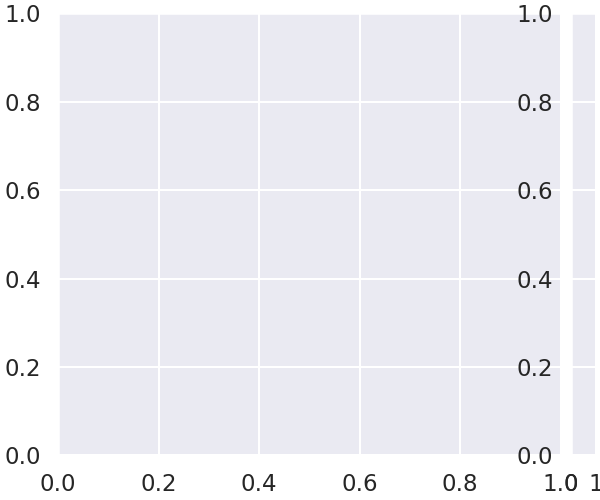

In [17]:
f2, f2_ax1 = plt.subplots(figsize=(6, 5), layout="constrained")

divider = make_axes_locatable(f2_ax1)
f2_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f2.add_axes(f2_cax1)

extent = [0, 0, 1060, 1030]

im_arr = get_single_image(scans[list(scans.keys())[-1]]['img_fname'], 0)
minmax = np.nanpercentile(im_arr, [5, 95])

canvas = Image(width=f2_ax1.get_figure().get_figwidth(), height=f2_ax1.get_figure().get_figheight())
canvas.data = im_arr
canvas.extent = extent

f2_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1], extent=extent)
plt.colorbar(f2_ax1.images[0], cax=f2_cax1)

@interact
def update_roi(ROI=canvas):
    global extent
    extent = ROI.extent
    f2_ax1.cla()
    f2_cax1.cla()

    f2_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1], extent=extent)
    plt.colorbar(f2_ax1.images[0], cax=f2_cax1)

display(f2, canvas)

### Show ROI sum

In [ ]:
f3, f3_ax1 = plt.subplots(figsize=(9, 6), layout='tight')

scan_widget = ipw.Dropdown(options=list(scans.keys()), value=list(scans.keys())[-1])

@interact(
    scan=scan_widget,
    log=False,
    ROI_y=ipw.IntRangeSlider(min=0, max=1065, value=(775, 785), step=1)
)
def show_ROI_sum(scan, log, ROI_y):
    [ax.cla() for ax in f3.get_axes()]

    spec_scan_number = int(scan[-3:]) - 1
    spec_file = SpecFile(scans[scan]['spec_fname'])
    spec_scan = spec_file[spec_scan_number]

    x_col = spec_file.command(spec_scan_number).split()[1]
    x_data = spec_scan.data_column_by_name(x_col)

    img_fname = scans[scan]['img_fname']
    ims = fabio.open(img_fname)
    
    roi_sum = []
    # for n in range(0, ims.getim in ims:
    for im in ims:
        im_arr = im.data.astype(float)
        im_arr[im_arr > 1e8] = np.nan
        # img = imgs.get_frame(n).data
        im_arr[514:551, :] = np.nan
        im_arr[0, 1029] = np.nan
    
        im_roi = im_arr[extent[1]:extent[3], extent[0]:extent[2]]
        #im_roi = im_arr[ROI_y[0]:ROI_y[1], extent[0]:extent[2]]
        roi_sum.append(np.nansum(im_roi))
        
    
    f3_ax1.plot(x_data, roi_sum, 'o-')
    if log:
        f3_ax1.set_yscale('log')
        
    f3_ax1.set_xlabel(x_col)
    f3_ax1.set_ylabel('Intensity [a.u.]')

In [ ]:
<pre>H K L =  -0.98649  0.41394  2.9368	 Lambda = 1.4879 Two Theta = 73.09

    Alpha      Beta       Psi       Tau       Qaz       Naz     Omega
  31.7395   36.3642   83.0173   20.0156   90.0000   66.4544   -2.2410

       del        eta        chi        phi         nu         mu 
  73.08979   34.30387   70.69531   82.80613    0.00000    0.00000 
</pre>

In [ ]:
  25.03734 - 50.58652/2 

In [ ]:
direct beam = (515, 772)
eta gz gx gy

In [18]:
IN040
umv eta -0.29511  gz  3.34297  gx -7.40054  gy  0.43038

umv chi 90.13891  phi 269.90941
a2scan del 2 90 eta 0.845195 44.845195 4400 1

SyntaxError: invalid syntax (55147178.py, line 2)

## Now

In [19]:
50.55152/2 -  25.33367

-0.05791000000000324

In [20]:
MF36-4
#umv eta -0.29105  gz  3.34359   gx 2.37927 gy  -0.01951

umv eta 0.46762  gz 3.34203 gx 2.37927 gy -0.01951

umv chi 90.29818 phi 269.40270
a2scan del 2 90 eta 1.2178 45.2178 4400 1 

umv chi 90.26318 phi 269.40270  # 0.5274

# 004 Peak
umv del 50.53152  eta 25.55398 chi 90.26318 phi 269.40269

th2th scan eta offset = 0.28822
a2scan del 2 90 eta 1.2882 45.2882 4400 1

SyntaxError: invalid syntax (1112603475.py, line 4)

In [ ]:
50.53152/2 -  25.55398

In [ ]:
MF37-1
#umv eta 0.08043  gz  3.33391 gx  -2.40060  gy  0.18044
umv eta 0.16801 gz 3.34172  gx -2.25064  gy 0.08047

umv chi 89.63861  phi 269.80371
a2scan del 2 90 eta 1.1236 45.1236 4400 1


umv chi 89.64625 phi 269.99379
a2scan del 2 90 eta 1.0579 45.0579 4400 1   # eta offset: 0.0579

In [21]:
MF101ca
#umv eta -0.38306 gz   3.33031 gx   7.52917 gy  -0.01951
umv eta 1.16801  gz  3.28812  gx  6.62940 gy  -0.03962

umv chi 90.37590 phi 270.00000
a2scan del 2 90 eta 1.14003 45.14003 4400 1

SyntaxError: invalid syntax (3374922095.py, line 3)

In [ ]:
79.61453   40.09500
79.71453   39.59051

In [22]:
40.09500 - 39.59051

0.504489999999997

In [23]:
# Taken OUT

IN043
setlat 3.868 3.868 3.868 90 90 90
umv eta -0.38306 gz   3.33031 gx   7.52917 gy  -0.01951

24.67760   12.08400   89.85000
dial_eta : 11.70094

umv chi 90.37590 phi 270.00000
a2scan del 2 90 eta 1.14003 45.14003 4400 1

SyntaxError: invalid syntax (58319092.py, line 4)

In [ ]:
MF101ca

4594.PSIC> pa

Psi-Circle Geometry

  Current mode:  Nu-fixed Psi-fixed Mu-fixed  (2 4 2)
 (Not using frozen angles)
Current sector:  None

  Primary Reflection (at lambda 0.826561):
   del eta chi phi nu mu = 50.584 25.0363 91.0563 270 -1.19209e-08 0 
                   H K L = 0 0 4

  Secondary Reflection (at lambda 0.826561):
   del eta chi phi nu mu = 39.4925 1.0758 90.659 270.06 -1.19209e-08 0 
                   H K L = 0 1 3

  Lattice Constants (lengths / angles):
              real space = 3.869 3.869 3.869 / 90 90 90
        reciprocal space = 1.624 1.624 1.624 / 90 90 90

  Azimuthal Reference:
                   H K L = 0 1 0
              (sigma tau = 90.233 178.74)

  Monochromator:
               d-spacing = 0 Angstroms
                  Energy = 15 keV
                  Lambda = 0.826561 

 Cut Points:
      del  eta  chi  phi   nu   mu
       -2   -2   -1   -1   -5   -5


In [ ]:
Psi-Circle Geometry

  Current mode:  Nu-fixed Psi-fixed Mu-fixed  (2 4 2)
 (Not using frozen angles)
Current sector:  None

  Primary Reflection (at lambda 0.826561):
   del eta chi phi nu mu = 50.584 25.0363 91.0563 270 -1.19209e-08 0 
                   H K L = 0 0 4

  Secondary Reflection (at lambda 0.826561):
   del eta chi phi nu mu = 39.4925 1.0758 90.659 270.06 -1.19209e-08 0 
                   H K L = 0 1 3

  Lattice Constants (lengths / angles):
              real space = 3.869 3.869 3.869 / 90 90 90
        reciprocal space = 1.624 1.624 1.624 / 90 90 90

  Azimuthal Reference:
                   H K L = 0 1 0
              (sigma tau = 90.233 178.74)

  Monochromator:
               d-spacing = 0 Angstroms
                  Energy = 15 keV
                  Lambda = 0.826561 


In [ ]:
50.58652   25.32750   89.64625  269.99379


In [ ]:
25.32750 - 25.03734

In [24]:
spec_fnames

NameError: name 'spec_fnames' is not defined

In [25]:
spec_scan = spec_file[2]

NameError: name 'spec_file' is not defined

In [ ]:
x_data = spec_scan.data_column_by_name('eta')

In [ ]:
img_files = img_h5s[sc]

img_fnames = [os.path.basename(img_file) for img_file in img_files]

## Show raw images

NameError: name 'img_fnames' is not defined

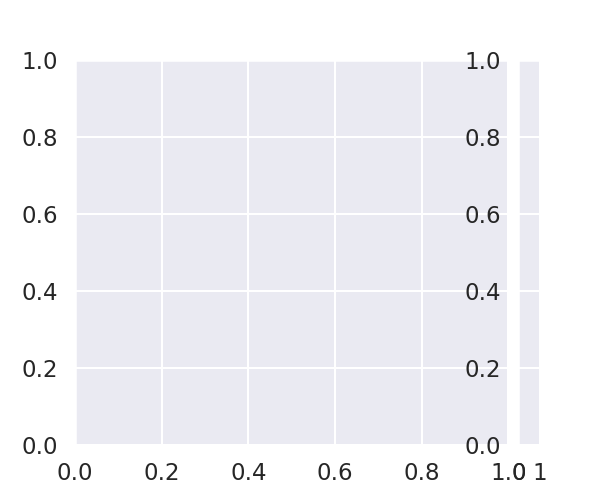

In [26]:
f1, f1_ax1 = plt.subplots(figsize=(6, 5))

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

scan_widget = ipw.Dropdown(options=img_fnames)
nimage_widget = ipw.IntSlider(min=0, max=1, step=1)
vminmax_widget = ipw.FloatRangeSlider(min=0, max=100, value=[5, 95], step=0.5)

@interact(
    scan=scan_widget,
    n=nimage_widget,
    vminmax=vminmax_widget
)
def show_raw_image(scan, n, vminmax):
    [ax.cla() for ax in f1.get_axes()]
    
    ims = fabio.open(scan)
    nimage_widget.max = ims.nframes - 1
    
    im_arr = get_single_image(scan, n)
    im_arr[im_arr > 1e8] = np.nan
    
    minmax = np.nanpercentile(im_arr, vminmax)
    im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
    plt.colorbar(im, cax=f1_cax1)
    
    def onselect(eclick, erelease):
        print(eclick.xdata, eclick.ydata)
        print(erelease.xdata, erelease.ydata)
    
    props = dict(facecolor='blue', alpha=0.5)
    rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
    rect_selector.add_state('square')

## Show ROI Sums

### Get ROI extents

In [ ]:
f1, f1_ax1 = plt.subplots(figsize=(6, 5), layout="constrained")

divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes("right", size="5%", pad=0.1)
f1.add_axes(f1_cax1)

ims = fabio.open(scans[0])

im_arr = get_single_image(scans[0], 0)
im_arr[im_arr > 1e8] = np.nan
   
minmax = np.nanpercentile(im_arr, [5, 95])
im = f1_ax1.imshow(im_arr, vmin=minmax[0], vmax=minmax[1])
plt.colorbar(im, cax=f1_cax1)
    
def onselect(eclick, erelease):
    global extent

    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    extent = [int(x.round()) for x in [x1, y1, x2, y2]]
    
    print(eclick.xdata, eclick.ydata)
    print(erelease.xdata, erelease.ydata)
    
    
props = dict(facecolor='blue', alpha=0.5)
rect_selector = RectangleSelector(f1_ax1, onselect, props=props, interactive=True)
rect_selector.add_state('square')

### Show ROI sum

In [ ]:
extent

In [ ]:
f2, f2_ax1 = plt.subplots(figsize=(6, 4))

scan_widget = ipw.Dropdown(options=scans)

@interact(
    scan=scan_widget,
)
def show_ROI_sum(scan):
    [ax.cla() for ax in f2.get_axes()]
    
    ims = fabio.open(scan)

    roi_sum = []
    for im in ims:
        im_arr = im.data
        im_roi = im_arr[extent[1]:extent[3], extent[0]:extent[2]]
        roi_sum.append(np.nansum(im_roi))
        
    
    f2_ax1.plot(x_data, roi_sum, 'o-')
    f2_ax1

In [27]:
int((extent[0]-0.4).round())

AttributeError: 'float' object has no attribute 'round'

In [ ]:
from matplotlib.widgets import EllipseSelector, RectangleSelector
import numpy as np
import matplotlib.pyplot as plt


def select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    global extent
    
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    
    extent = [x1, y1, x2, y2
             ]
    print(f"({x1:3.2f}, {y1:3.2f}) --> ({x2:3.2f}, {y2:3.2f})")
    print(f"The buttons you used were: {eclick.button} {erelease.button}")
    

def toggle_selector(event):
    print('Key pressed.')
    if event.key == 't':
        for selector in selectors:
            name = type(selector).__name__
            if selector.active:
                print(f'{name} deactivated.')
                selector.set_active(False)
            else:
                print(f'{name} activated.')
                selector.set_active(True)


fig = plt.figure(layout='constrained')
axs = fig.subplots(2)

N = 100000  # If N is large one can see improvement by using blitting.
x = np.linspace(0, 10, N)

selectors = []
for ax, selector_class in zip(axs, [RectangleSelector, EllipseSelector]):
    ax.plot(x, np.sin(2*np.pi*x))  # plot something
    ax.set_title(f"Click and drag to draw a {selector_class.__name__}.")
    selectors.append(selector_class(
        ax, select_callback,
        useblit=True,
        button=[1, 3],  # disable middle button
        minspanx=5, minspany=5,
        spancoords='pixels',
        interactive=True))
    fig.canvas.mpl_connect('key_press_event', toggle_selector)
axs[0].set_title("Press 't' to toggle the selectors on and off.\n"
                 + axs[0].get_title())
plt.show()

In [ ]:
extent